# Characterize Taggart, Novel, All BPs

For each group plot:
- Phastcons
- PhyloP
- Distance from 3'ss
- PWM

both seperately and all on one plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
bases = ['A', 'C', 'G', 'T']

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [4]:
# file is result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_taggart.tsv') as fp:
    for line in fp:
        chrom, start, end, gene, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        gene = gene.split(':')[-1]
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand, gene)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)
print known.keys()[0]

22020
184272
('chr17', 40054092, '-', 'ACLY')


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands, genes = [], [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand, gene = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three - 1
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
        genes += [gene]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords),
            np.array(strands), np.array(genes))

(X_known, y_known,
 k_chroms, k_coords,
 k_strands, k_genes) = encode(known, phastcons, phylop)
(X_novel, y_novel, 
 n_chroms, n_coords,
 n_strands, n_genes) = encode(missing, phastcons, phylop)

print np.sum(y_novel), np.sum(y_known)
print X_novel.shape, X_known.shape

0.0 25324.0
(184272, 70, 6) (22020, 70, 6)


In [7]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [8]:
y_novel = model.predict(X_novel[:, :, :4]).reshape(-1, L)
p_known = model.predict(X_known[:, :, :4]).reshape(-1, L)

X_all = np.vstack([X_novel, X_known])
y_all = np.vstack([y_novel, p_known])

In [9]:
a_chroms  = np.hstack([n_chroms,  k_chroms])
a_coords  = np.hstack([n_coords,  k_coords])
a_strands = np.hstack([n_strands, k_strands])
a_genes = np.hstack([n_genes, k_genes])

## Conservation Meta

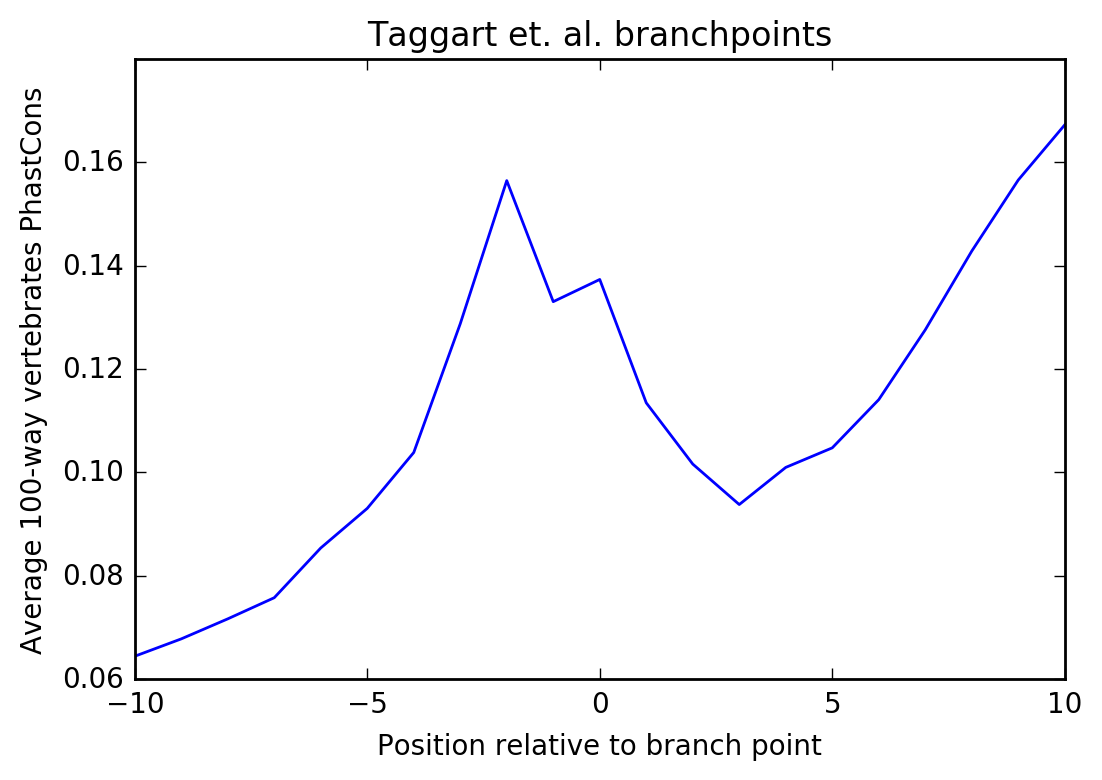

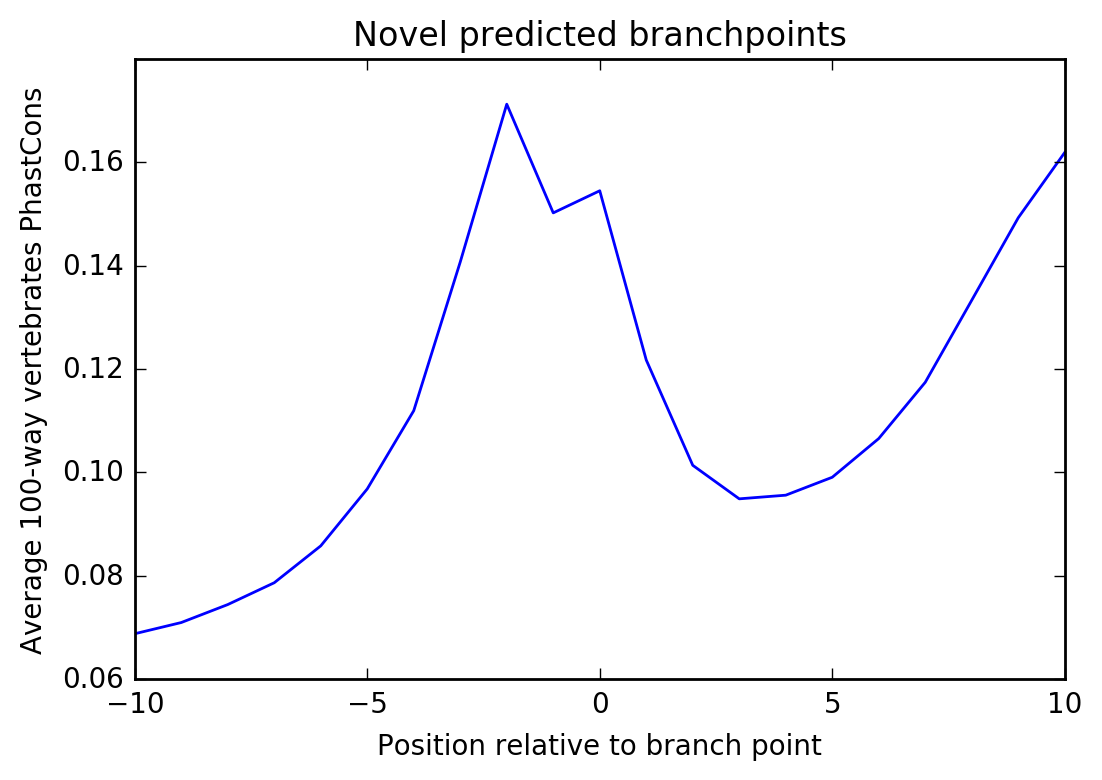

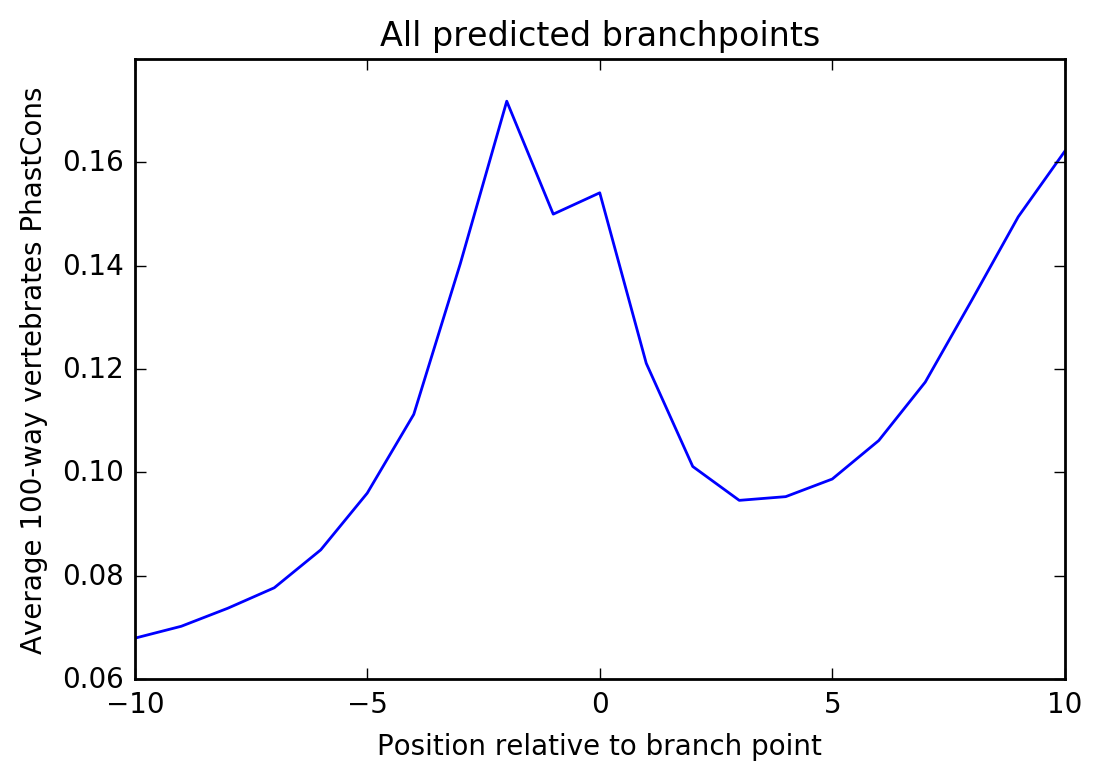

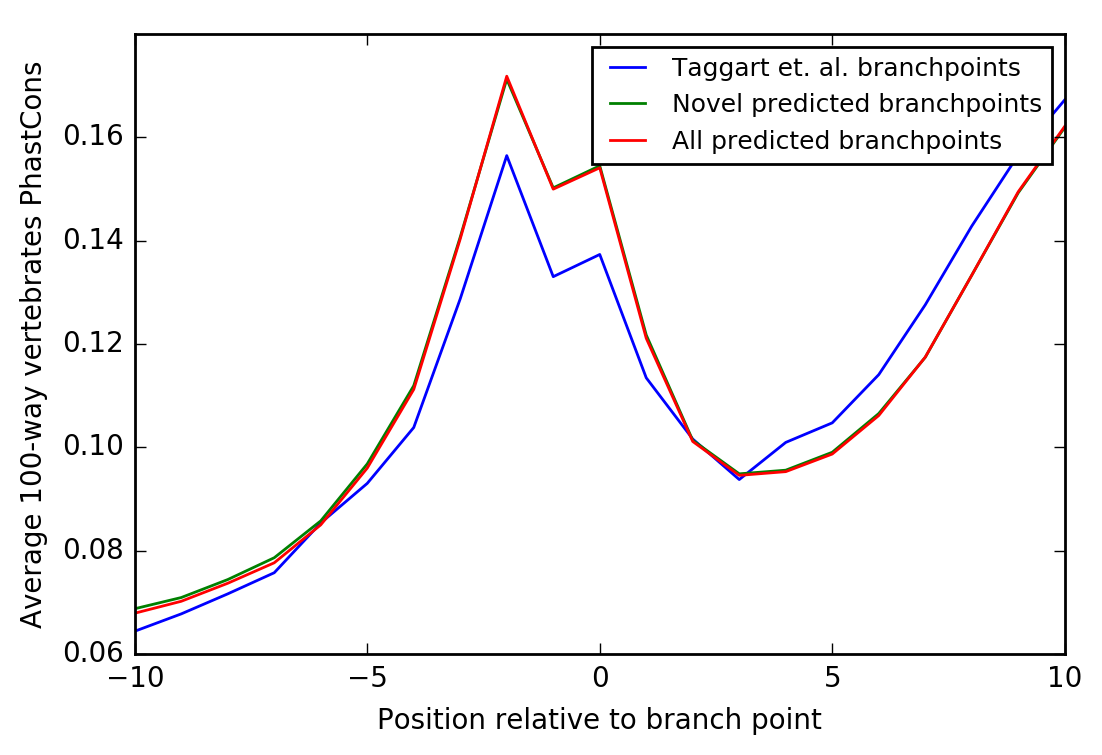

In [10]:
K = 10

def cons_known(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            counts = counts + seq[bp-K: bp+K+1, idx]
            total += 1
    return counts / total

def cons_novel(X, y, idx):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, idx]
        total += 1
    return counts / total

known = cons_known(X_known, y_known, 4)
novel = cons_novel(X_novel, y_novel, 4)
allbp = cons_novel(X_all,   y_all,   4)

names = ['Taggart et. al. branchpoints',
         'Novel predicted branchpoints',
         'All predicted branchpoints']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhastCons')
plt.legend(loc = 1, prop={'size':9})
plt.show()

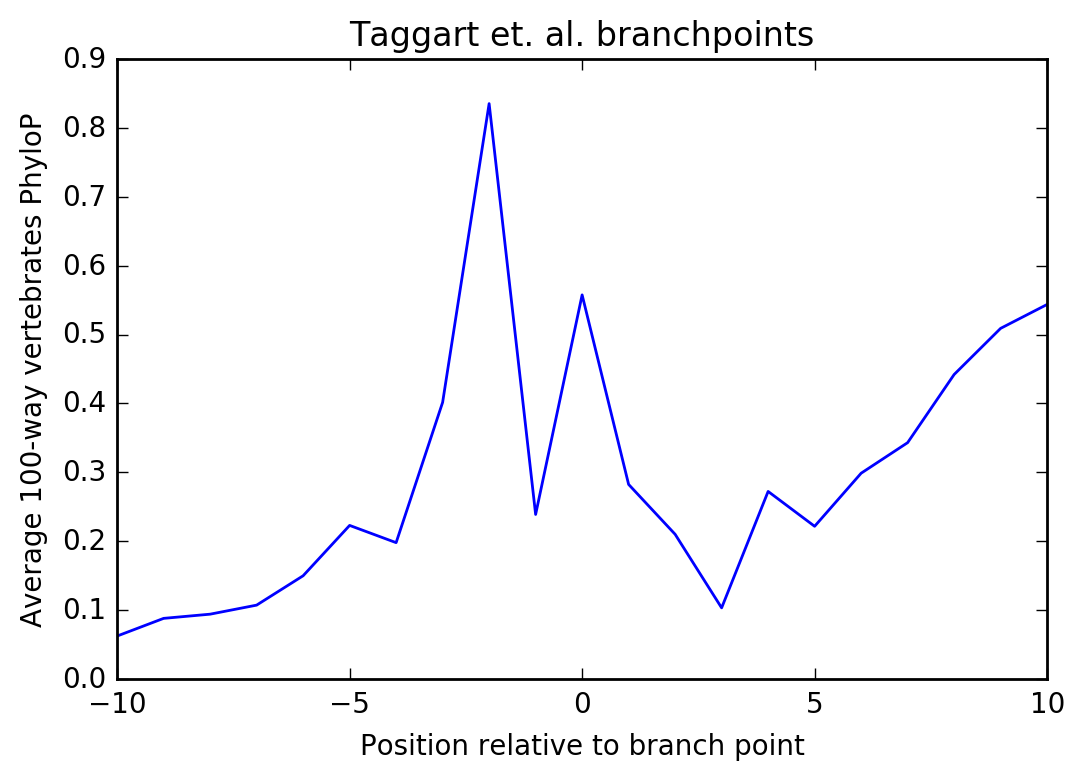

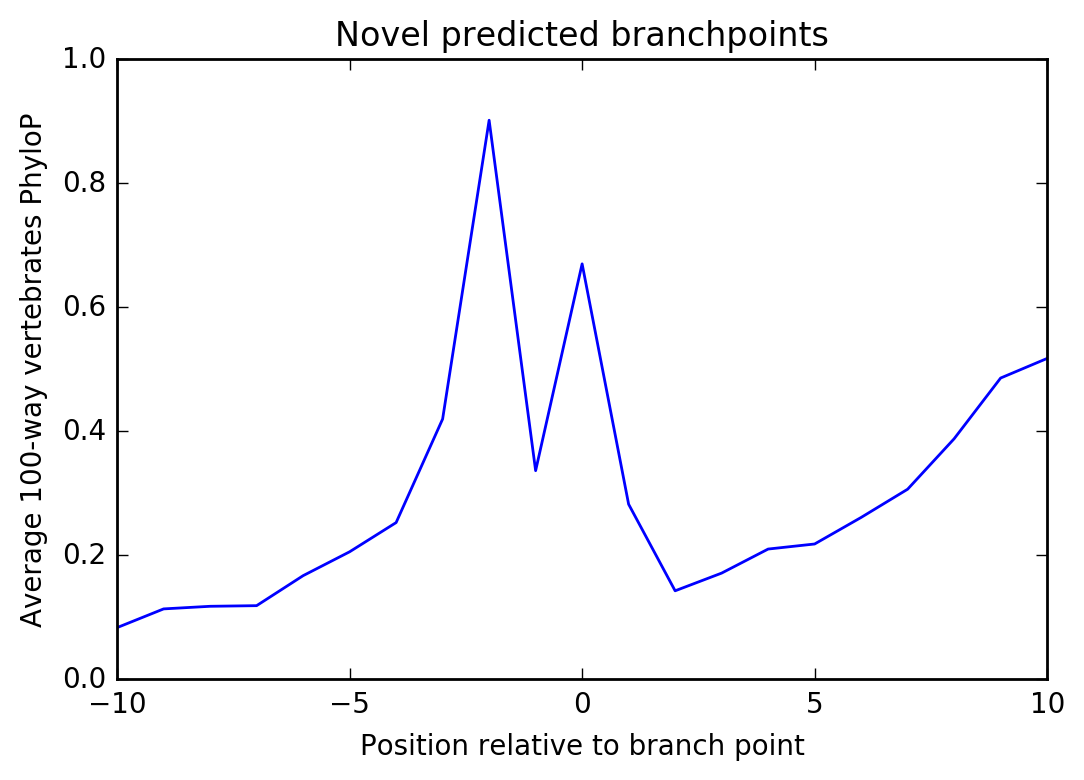

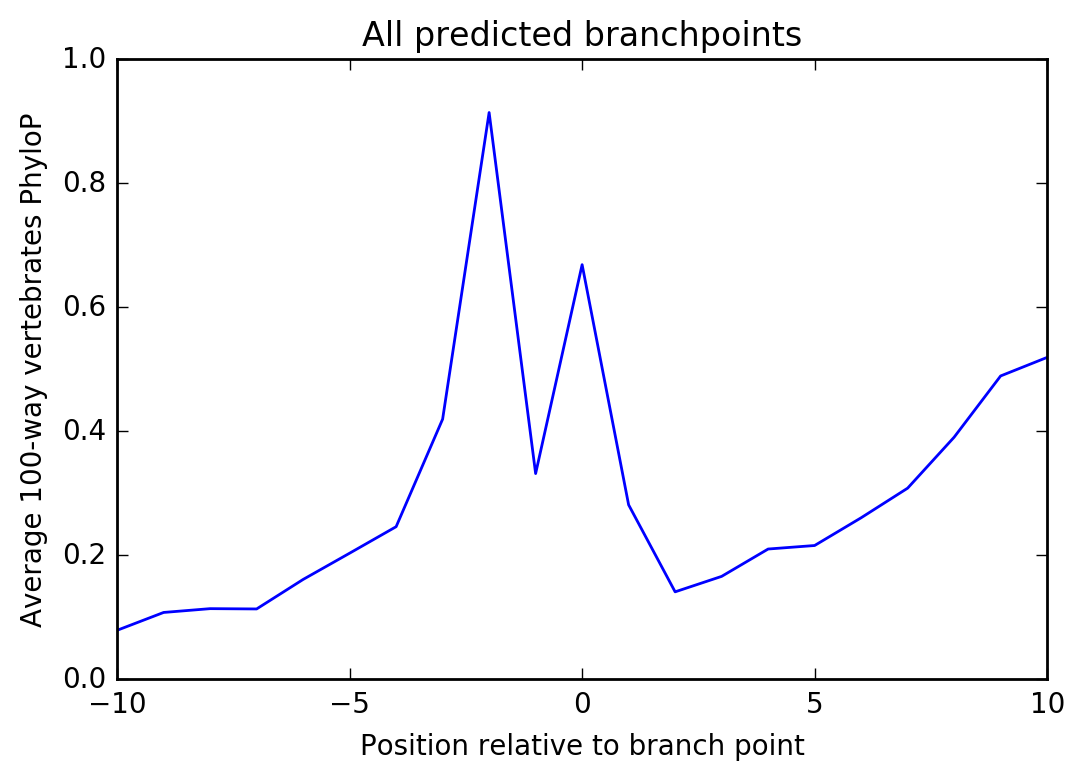

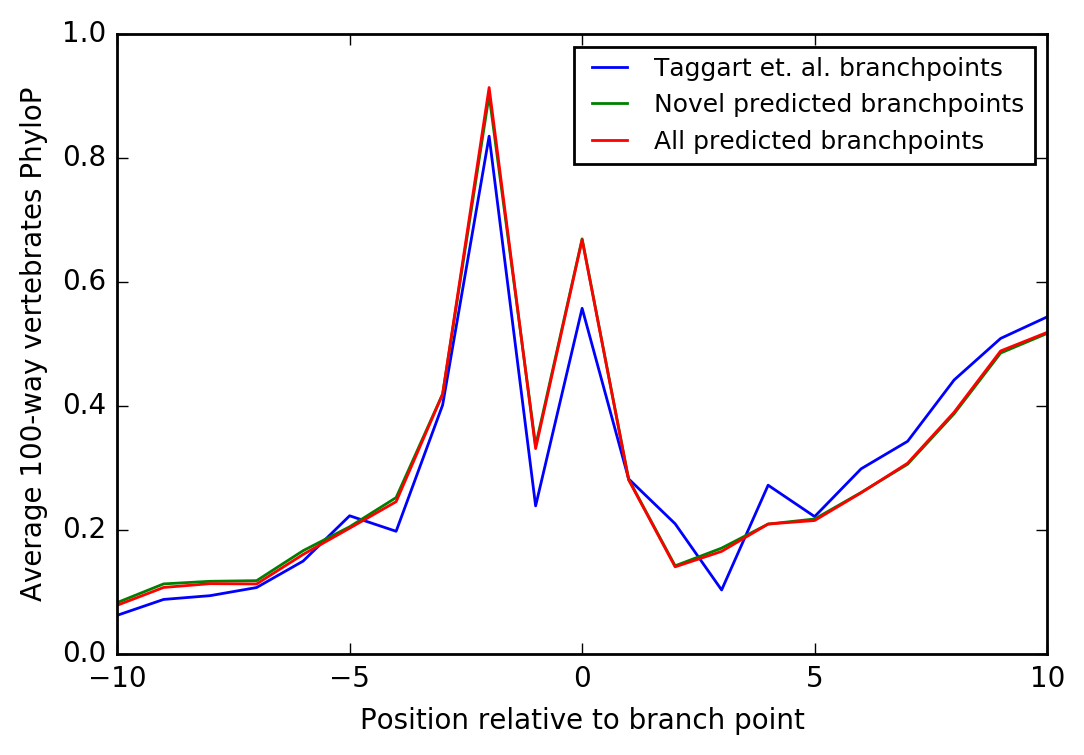

In [11]:
known = cons_known(X_known, y_known, 5)
novel = cons_novel(X_novel, y_novel, 5)
allbp = cons_novel(X_all,   y_all,   5)

names = ['Taggart et. al. branchpoints',
         'Novel predicted branchpoints',
         'All predicted branchpoints']
cons = [known, novel, allbp]

for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.show()
    
for name, con in zip(names, cons):
    plt.plot(range(-K, K+1), con, label = name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
plt.legend(loc = 1, prop={'size':9})
plt.show()

17776


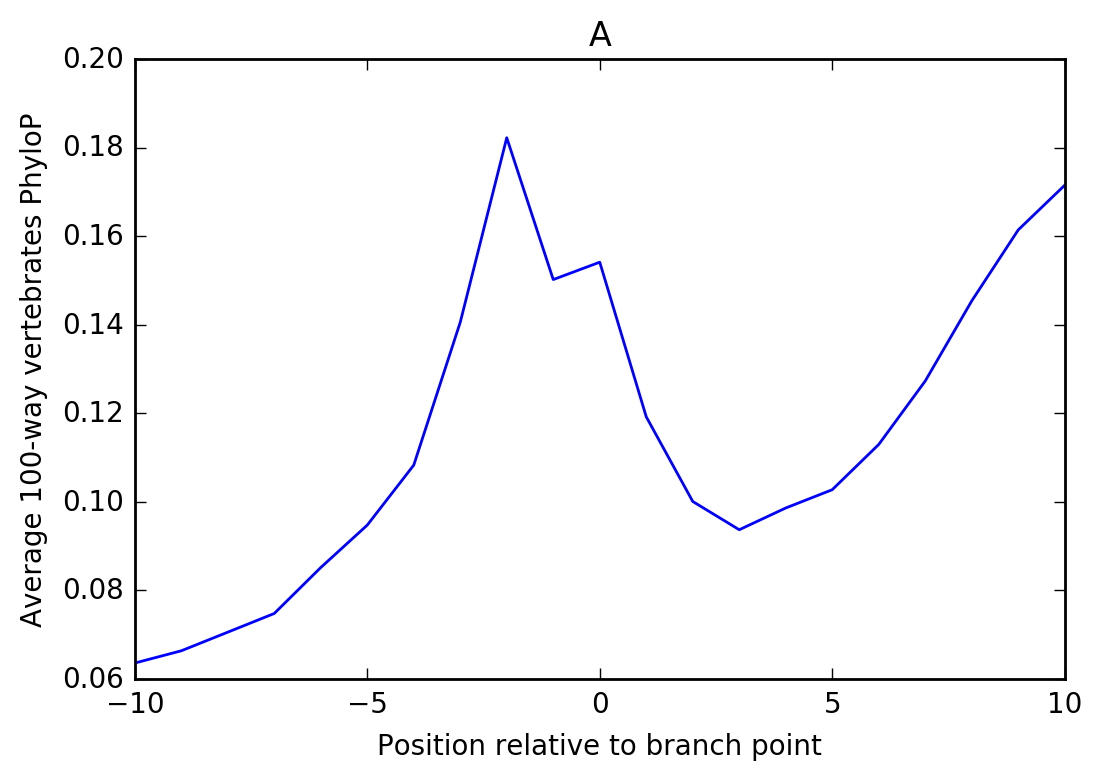

3769


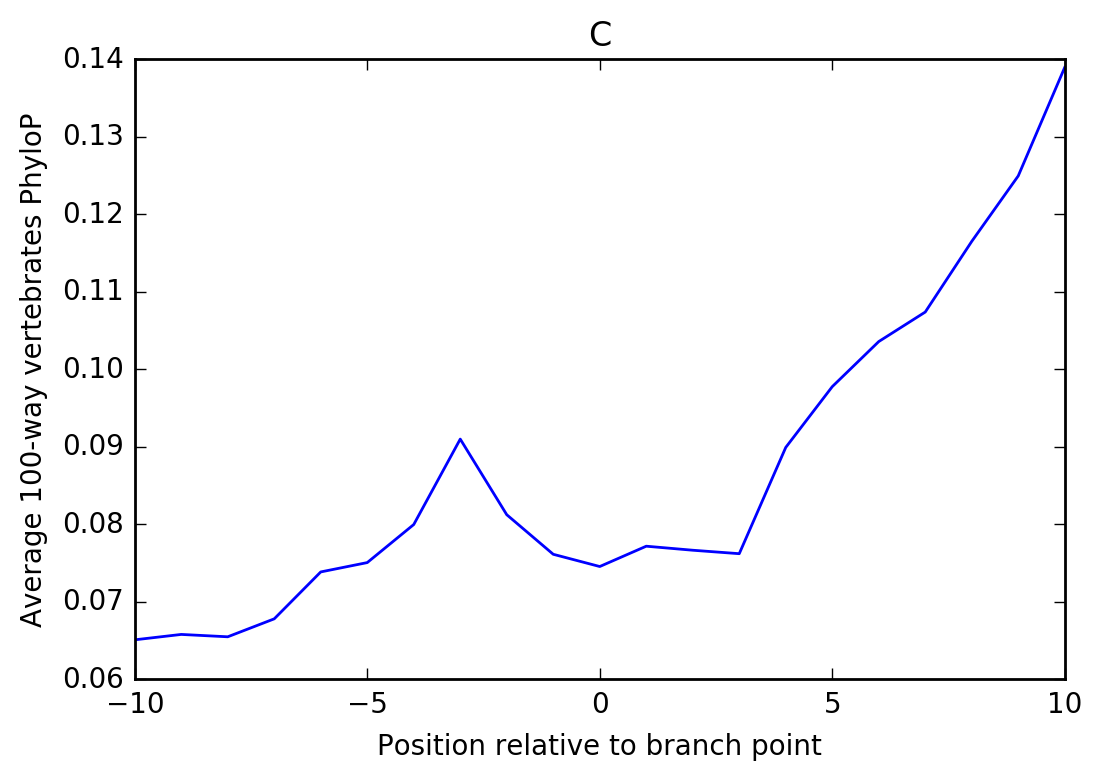

1054


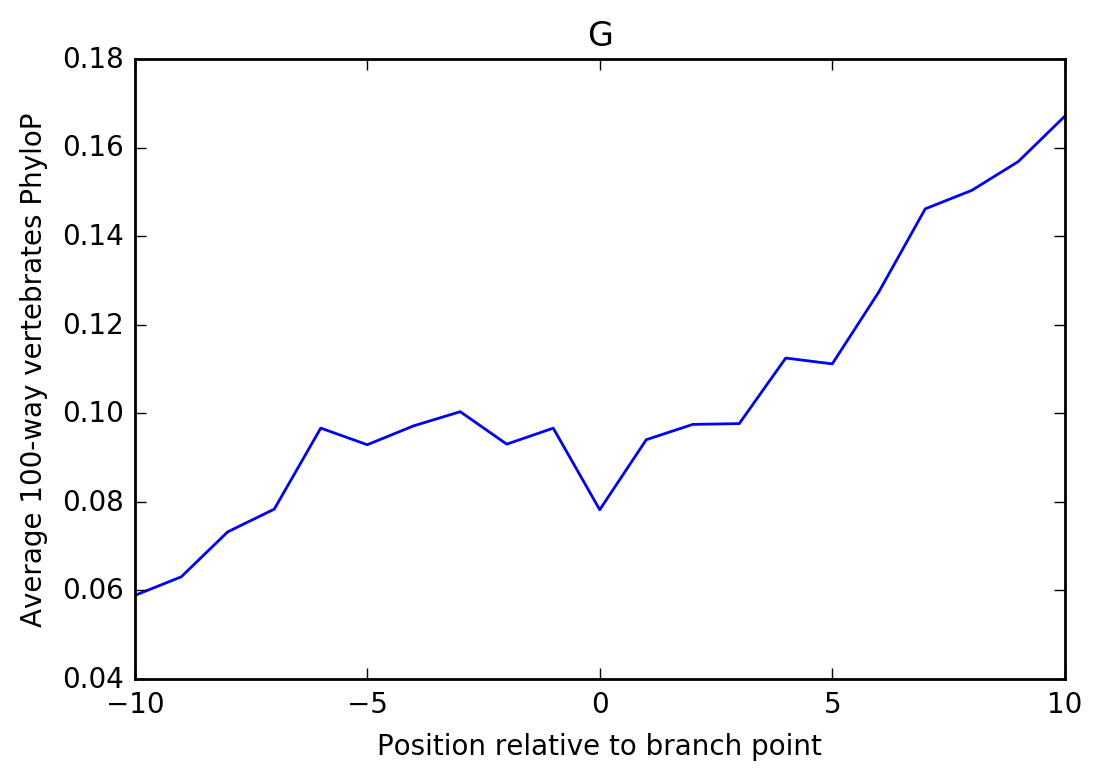

2549


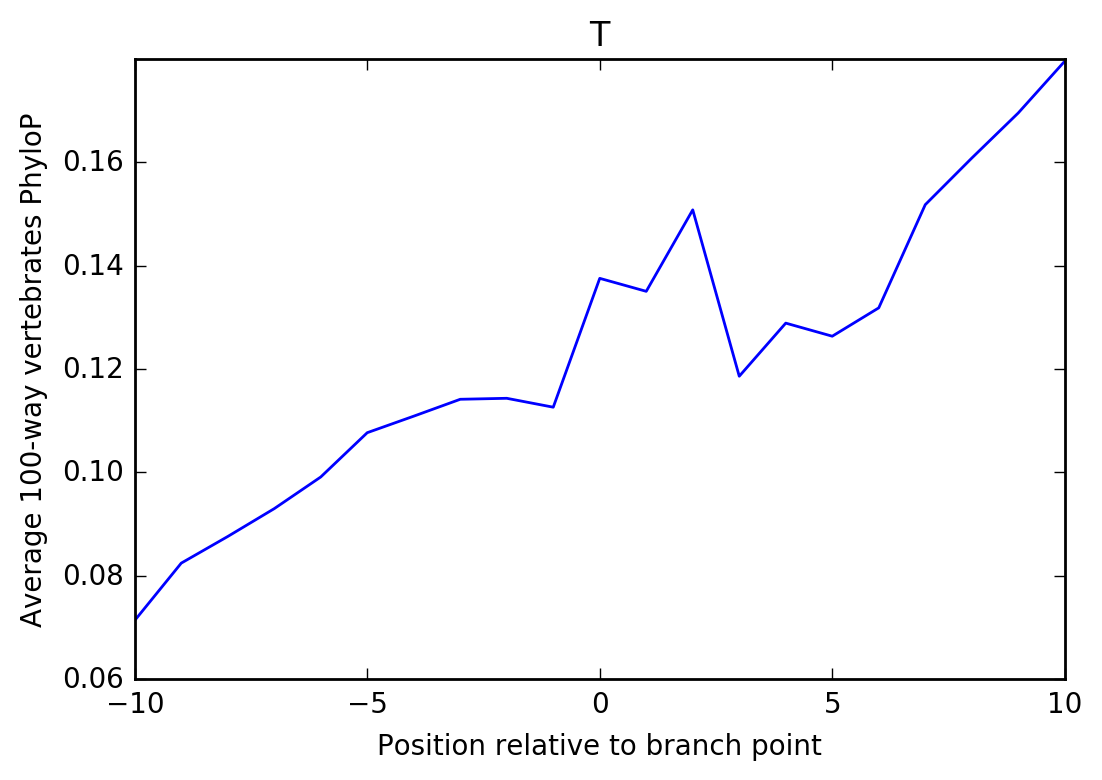

17776


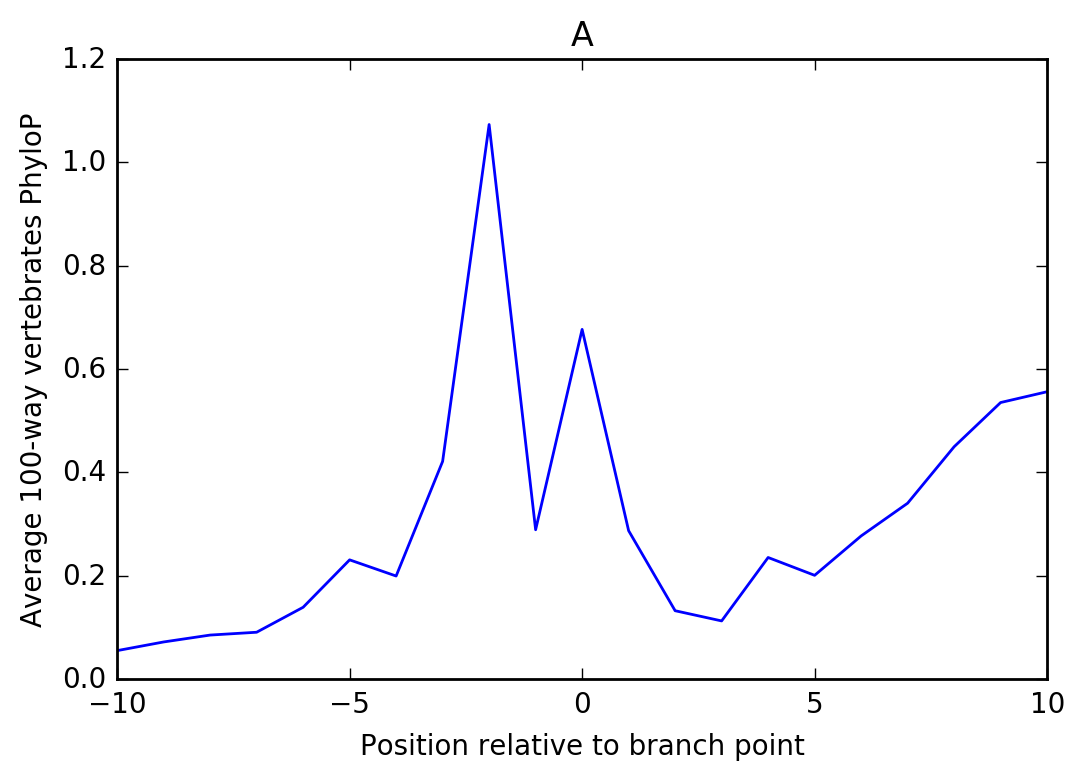

3769


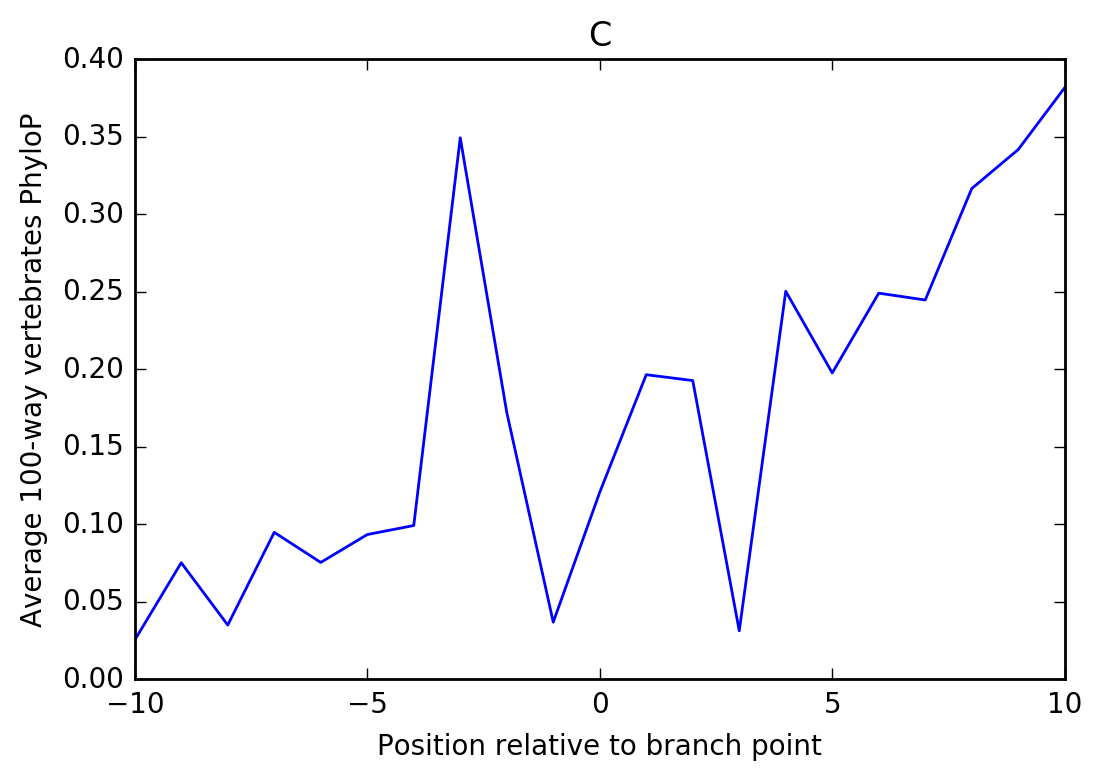

1054


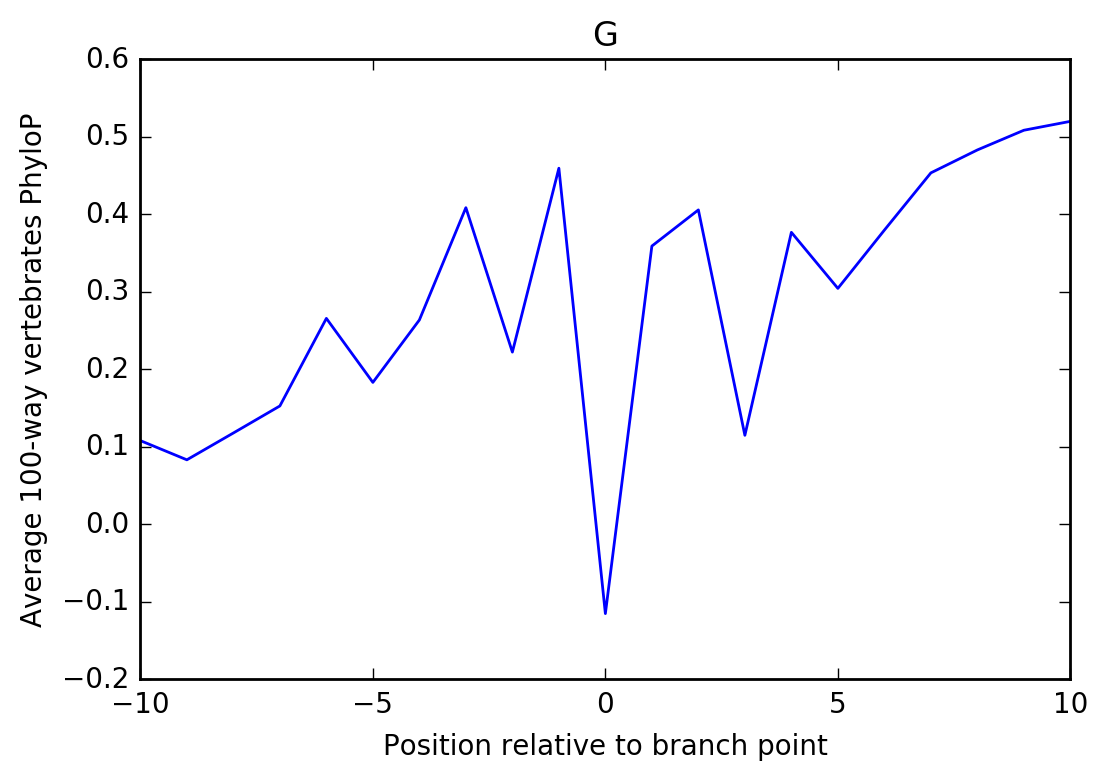

2549


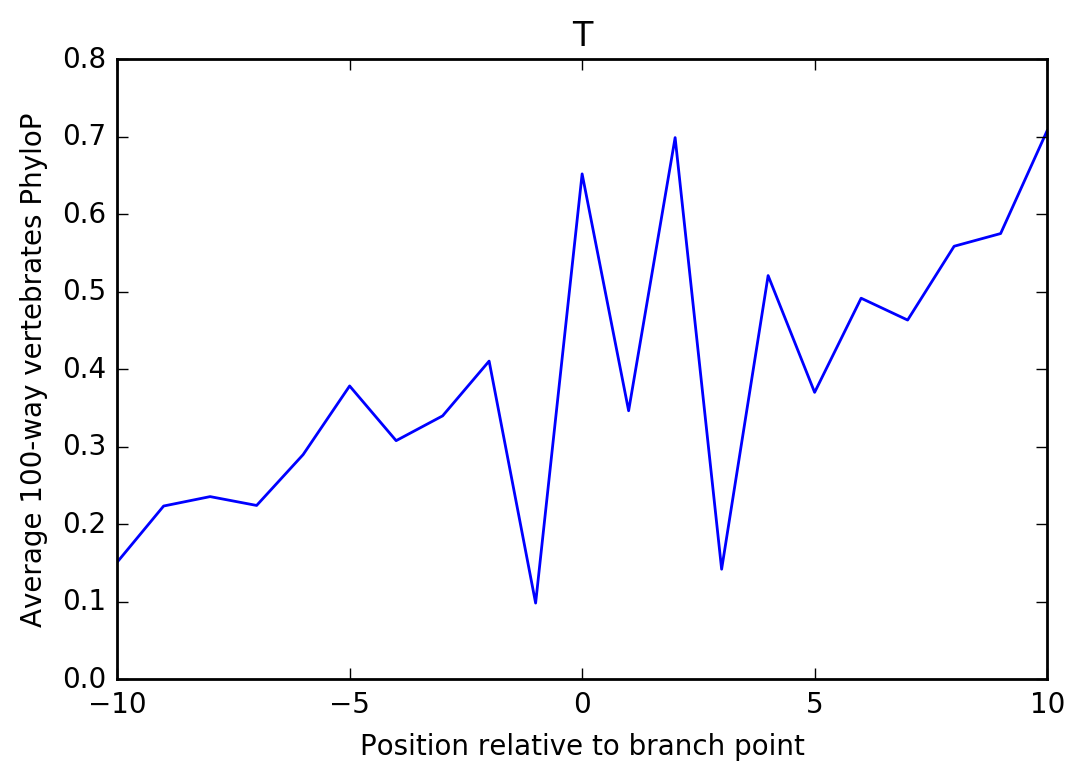

In [12]:
# By BP nucleotide

def cons_known_base(X, y, idx, base):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, base]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

K = 10
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
             cons_known_base(X_known, y_known, 4, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1),
              cons_known_base(X_known, y_known, 5, i), label = base)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Average 100-way vertebrates PhyloP')
    plt.title(base)
    plt.show()

19196
5952


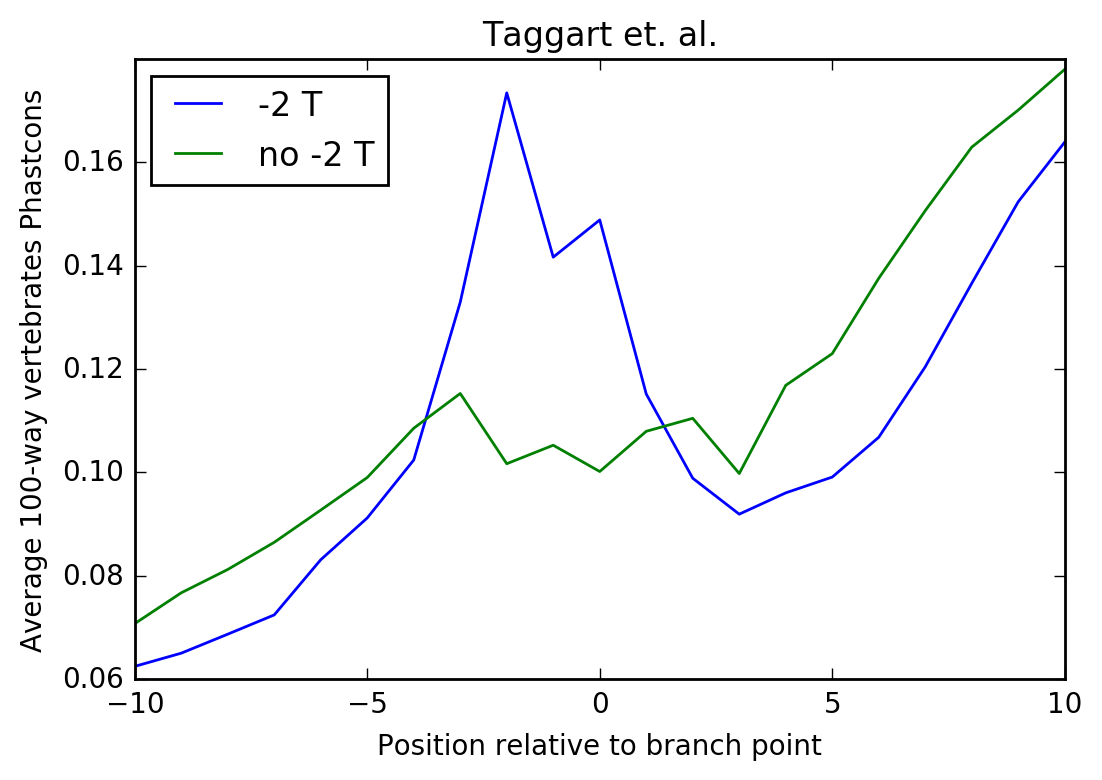

19196
5952


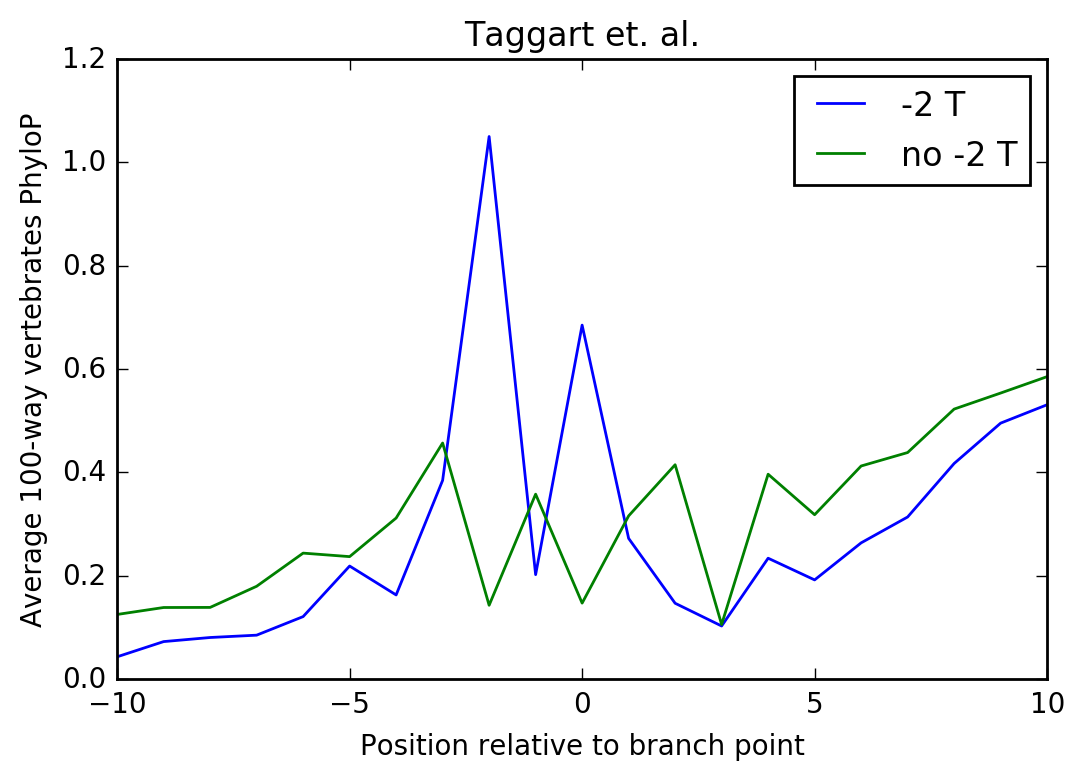

In [13]:
def cons_known_T(X, y, idx, T):
    counts = np.zeros((2*K+1,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if T==seq[bp-2, 3]: continue
            counts += seq[bp-K: bp+K+1, idx]
            total += 1
    print total
    return counts / total

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 4, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates Phastcons')
plt.title('Taggart et. al.')
plt.legend(loc = 'best')
plt.show()

for t, name in enumerate(['-2 T','no -2 T']):
    K = 10
    plt.plot(range(-K, K+1),
             cons_known_T(X_known, y_known, 5, t), label = name)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhyloP')
plt.title('Taggart et. al.')
plt.legend(loc = 'best')
plt.show()

## Dists

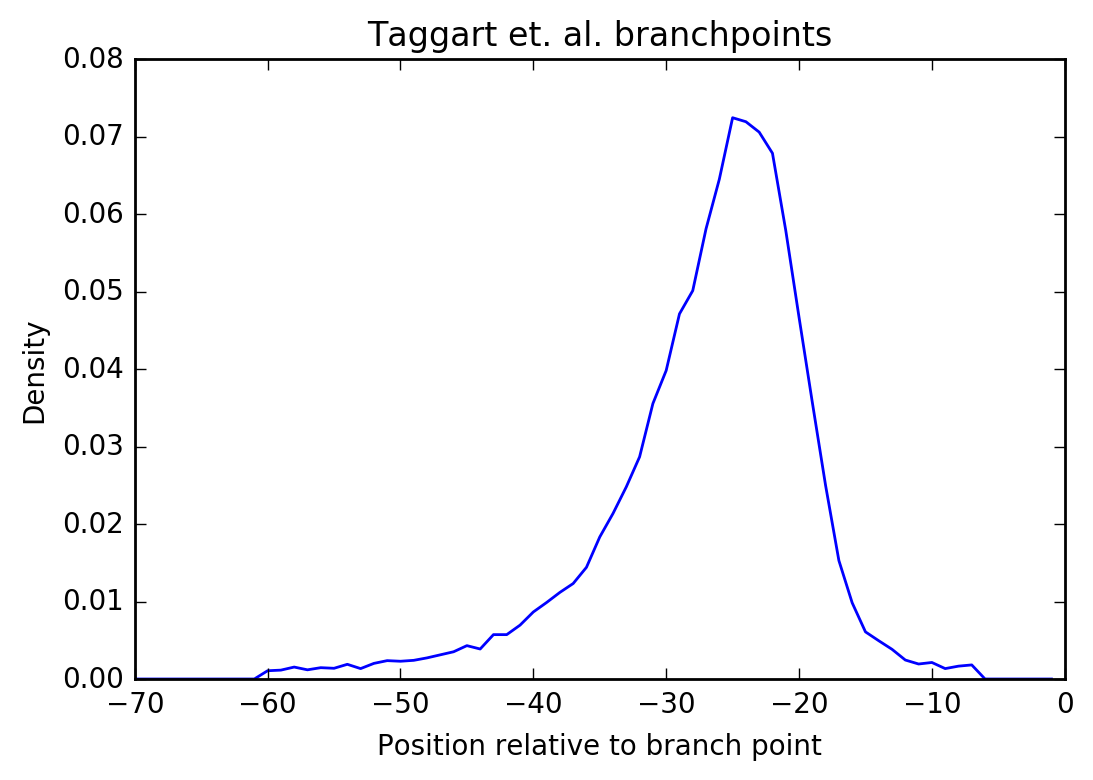

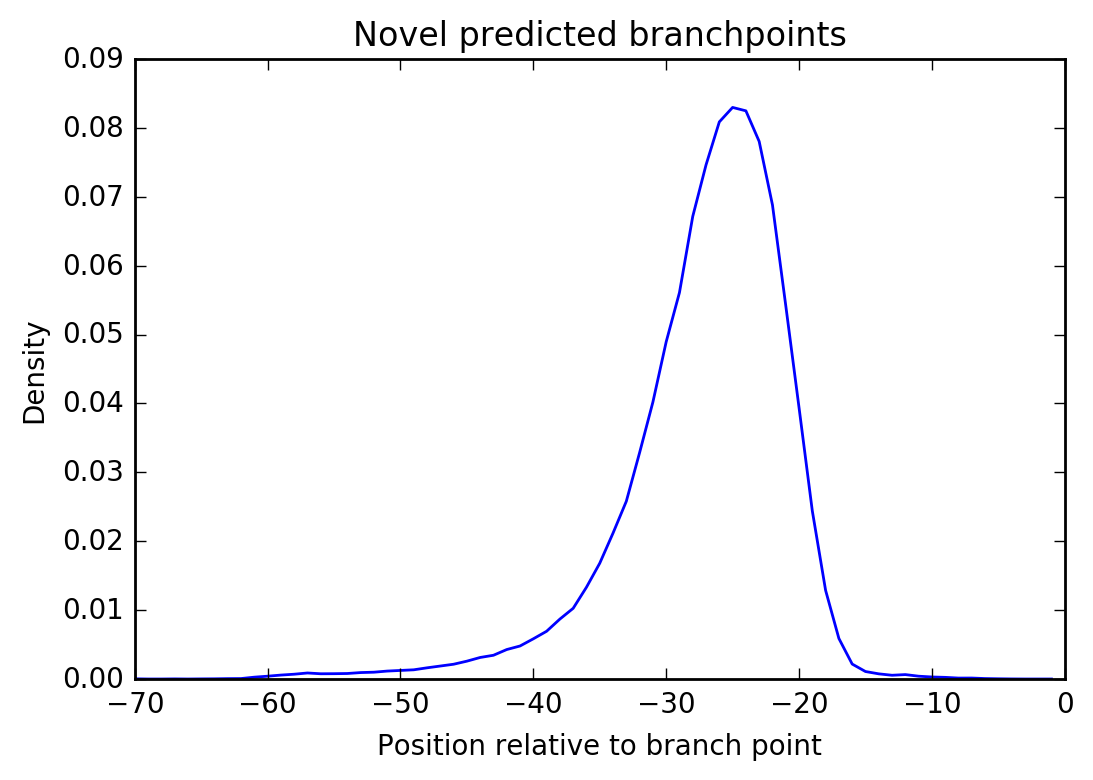

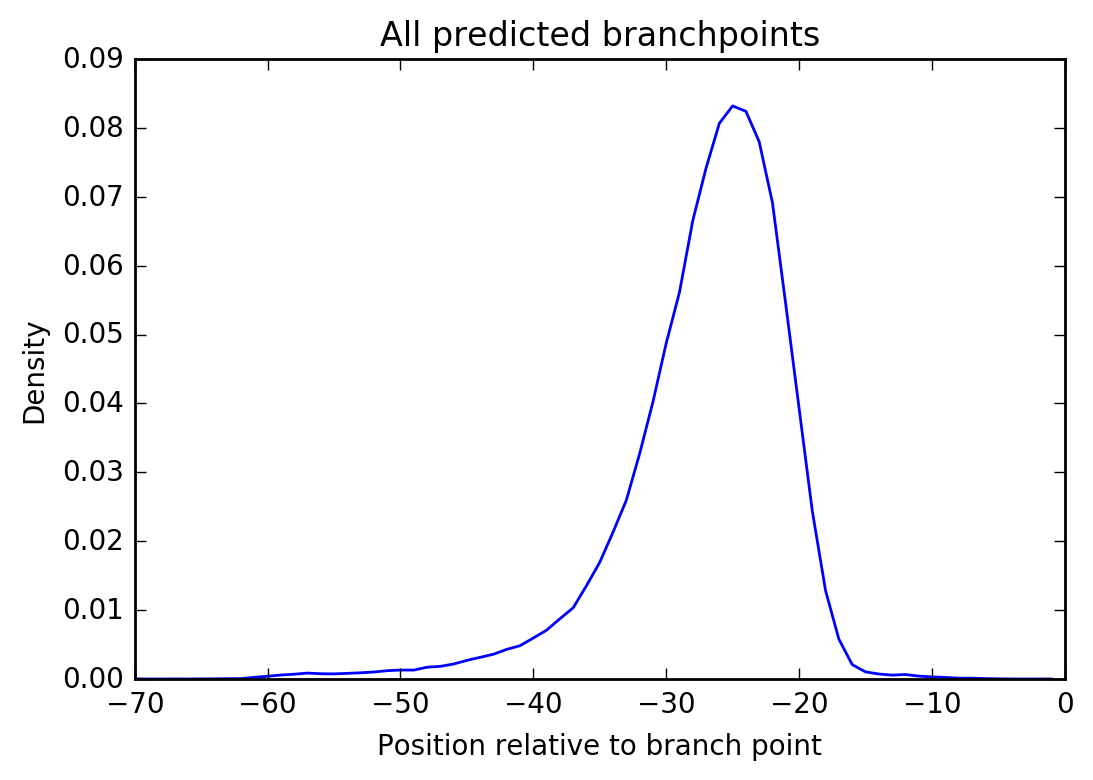

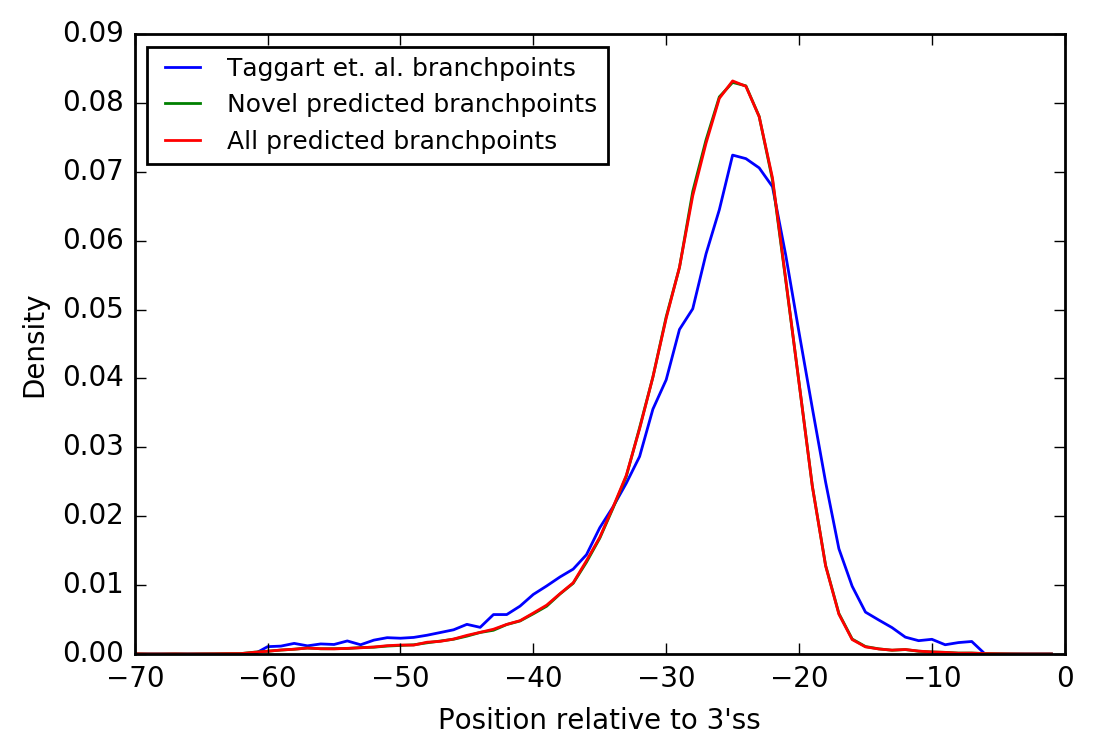

In [14]:
def dist_known(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        for bp in np.nonzero(target)[0]:
            counts[bp] += 1
            total += 1
    return counts / total

def dist_novel(X, y, idx):
    counts = np.zeros((L,))
    total = 0
    for target, seq in zip(y, X):
        bp = np.argmax(target)
        counts[bp] += 1
        total += 1
    return counts / total

known = dist_known(X_known, y_known, 4)
novel = dist_novel(X_novel, y_novel, 4)
allbp = dist_novel(X_all,   y_all,   4)

dists = [known, novel, allbp]

for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist)
    plt.title(name)
    plt.xlabel('Position relative to branch point')
    plt.ylabel('Density')
    plt.show()
    
for name, dist in zip(names, dists):
    plt.plot(range(-L, 0), dist, label = name)
    plt.xlabel("Position relative to 3'ss")
    plt.ylabel('Density')
plt.legend(loc = 2, prop={'size':9})
plt.show()

## PWM

In [15]:
def adjustFigAspect(fig,aspect=1):
    '''
    Adjust the subplot parameters so that the figure has the correct
    aspect ratio.
    '''
    xsize,ysize = fig.get_size_inches()
    minsize = min(xsize,ysize)
    xlim = .4*minsize/xsize
    ylim = .4*minsize/ysize
    if aspect < 1:
        xlim *= aspect
    else:
        ylim /= aspect
    fig.subplots_adjust(left=.5-xlim,
                        right=.5+xlim,
                        bottom=.5-ylim,
                        top=.5+ylim)

def pwm_logo(pwm, title, x=None, aspect = 2.5):
    fig = plt.figure(figsize=(10,5))
    adjustFigAspect(fig,aspect=aspect)

    ax = fig.add_subplot(111)
    #f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'U'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax.bar(bar_l,
               pwm[:, i],
               width=bar_width,
               label=char,
               bottom=np.sum(pwm[:, :i], axis = 1),
               alpha=0.5,
               color = color)
    plt.xticks(tick_pos, x if x else range(-K, K+1))
    plt.legend(loc = 1, prop={'size':9})
    plt.title(title)
    plt.ylim(0, 1)
    plt.xlim(.75, len(x)+1 if x else 2*K+2)
    plt.show()

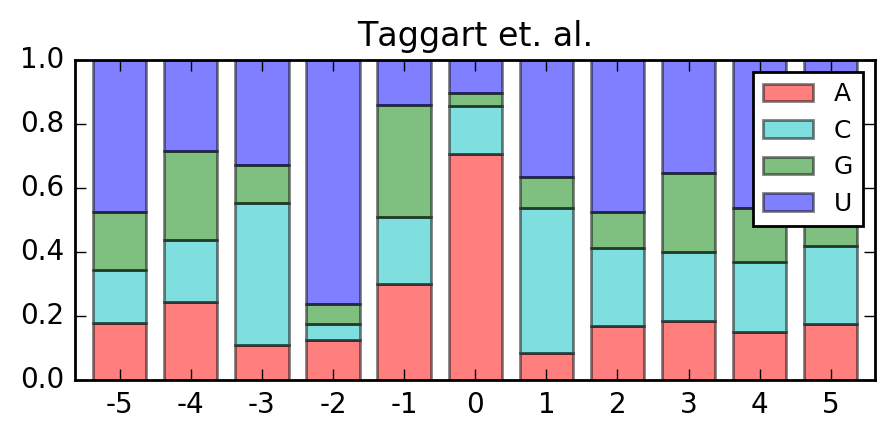

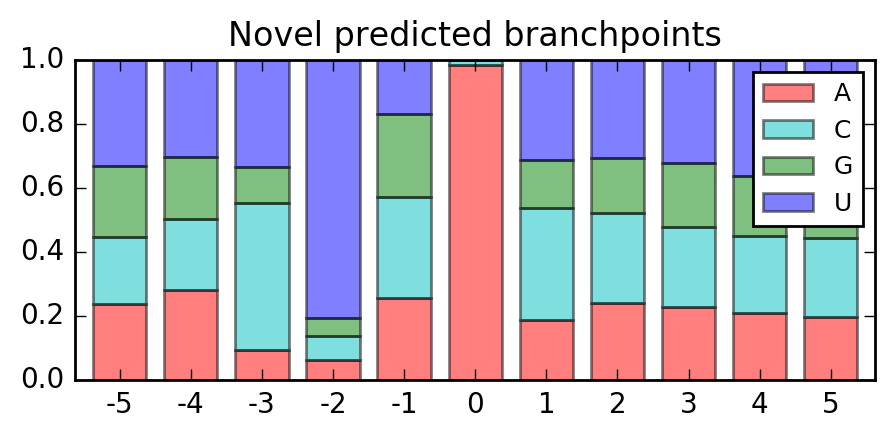

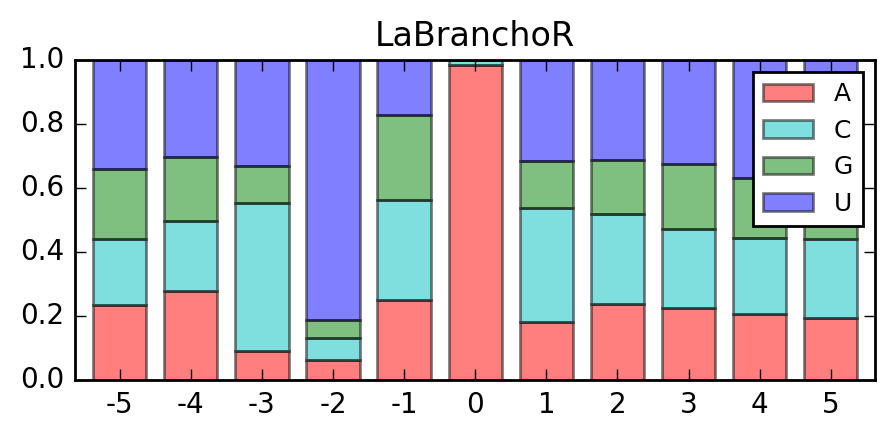

In [16]:
# Known
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_known, X_known):
    for bp in np.nonzero(target)[0]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm_logo(counts / total, 'Taggart et. al.')

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_novel, X_novel):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, names[1])

# Novel
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
pwm_logo(counts / total, 'LaBranchoR')

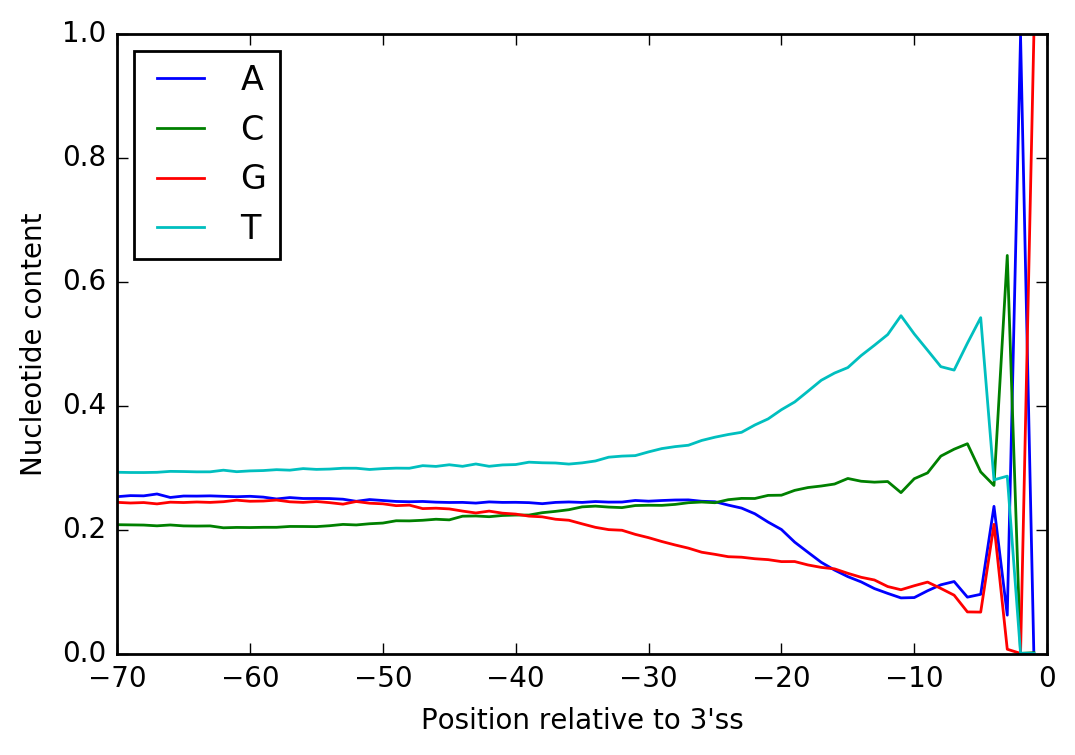

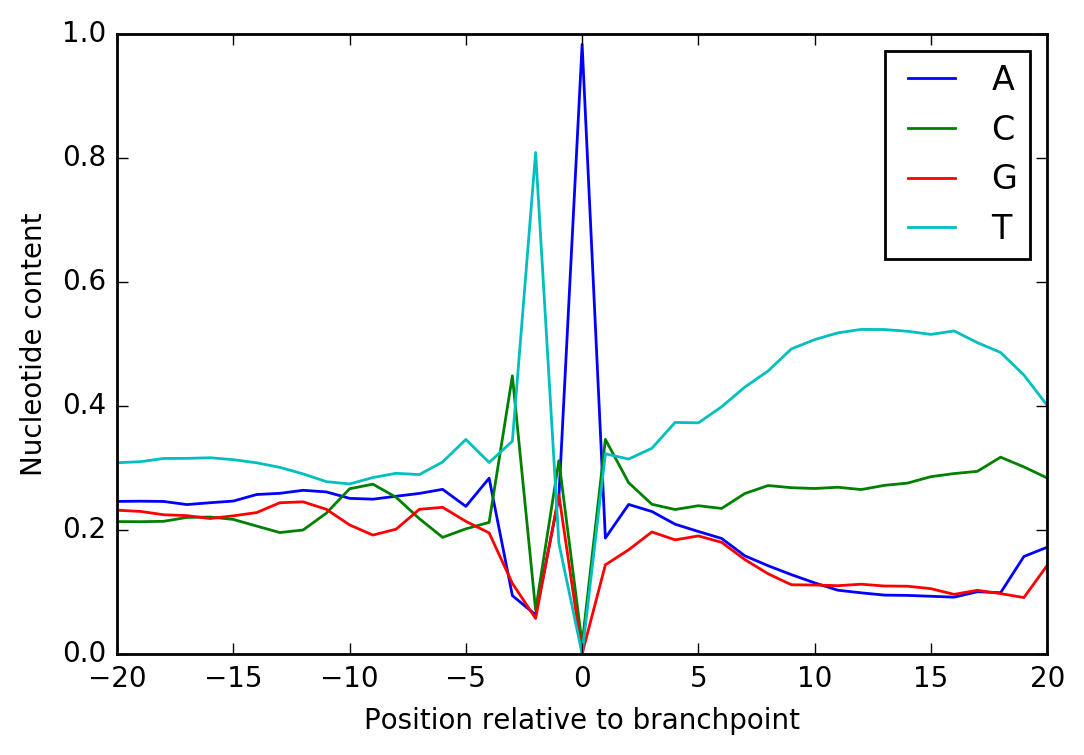

In [16]:
for i, base in enumerate(bases):
    plt.plot(range(-70, 0), X_all[:, :, i].mean(axis = 0), label = base)
plt.legend(loc='best')
plt.xlabel("Position relative to 3'ss")
plt.ylabel('Nucleotide content')
plt.show()

K = 20
for i, base in enumerate(bases):
    plt.plot(range(-K, K+1), cons_novel(X_all, y_all, i), label = base)
plt.legend(loc='best')
plt.xlabel('Position relative to branchpoint')
plt.ylabel('Nucleotide content')
plt.show()

In [17]:
bps = []
for seq, bp in zip(X_all, np.argmax(y_all,axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
bps = np.vstack(bps)
print bps.shape

from sklearn.utils import shuffle
shuffle_bps = []
for seq, bp in zip(X_all, np.argmax(shuffle(y_all),axis = 1)):
    if bp-20 < 0 or bp+23 > L: continue
    shuffle_bps += [seq[bp-20:bp+23, :4].reshape(1, -1, 4)]
shuffle_bps = np.vstack(shuffle_bps)
print shuffle_bps.shape

(160785, 43, 4)
(160785, 43, 4)


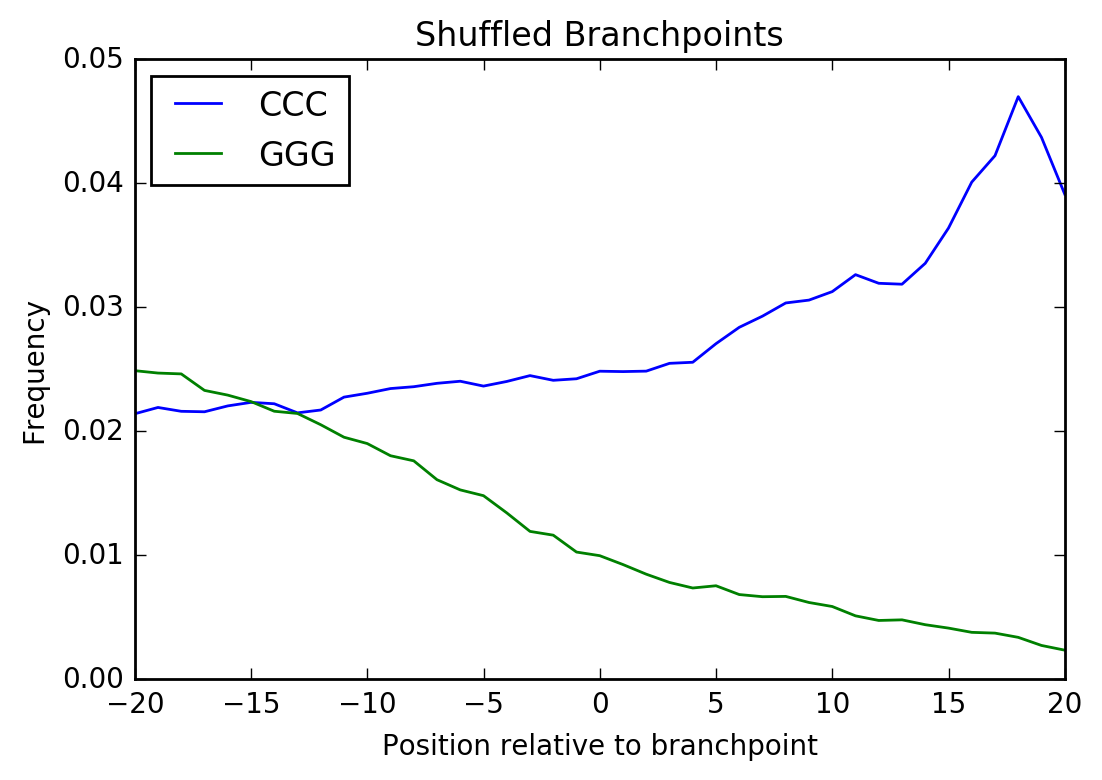

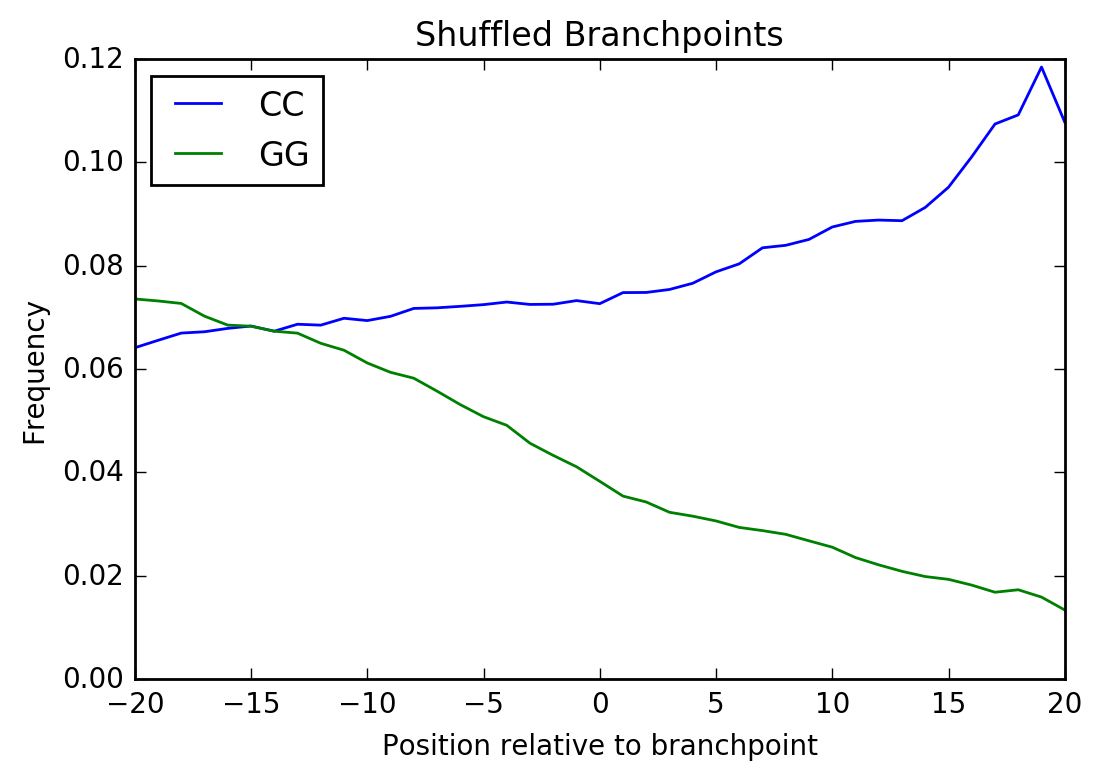

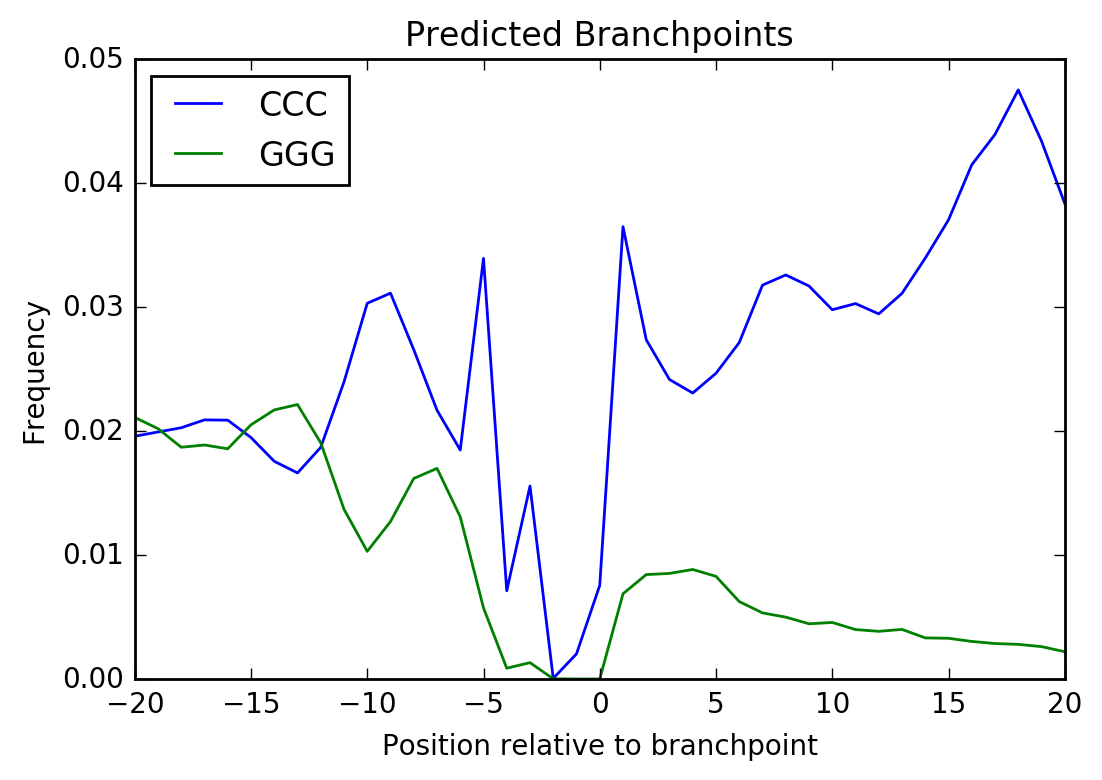

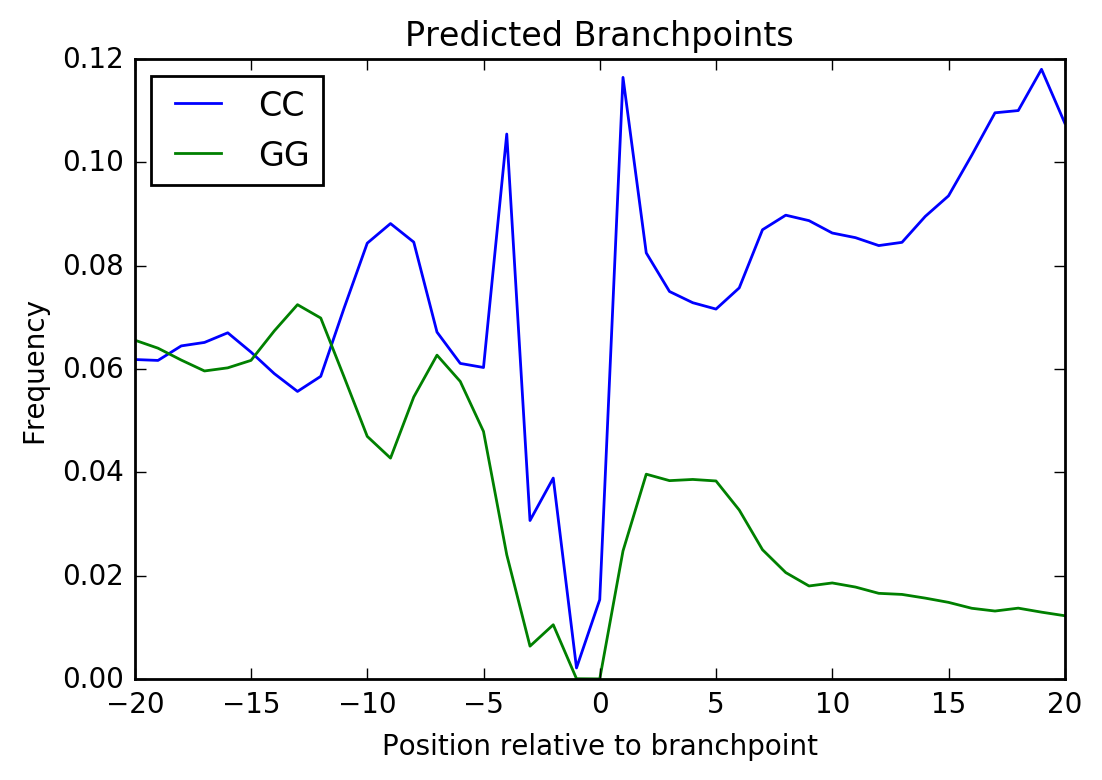

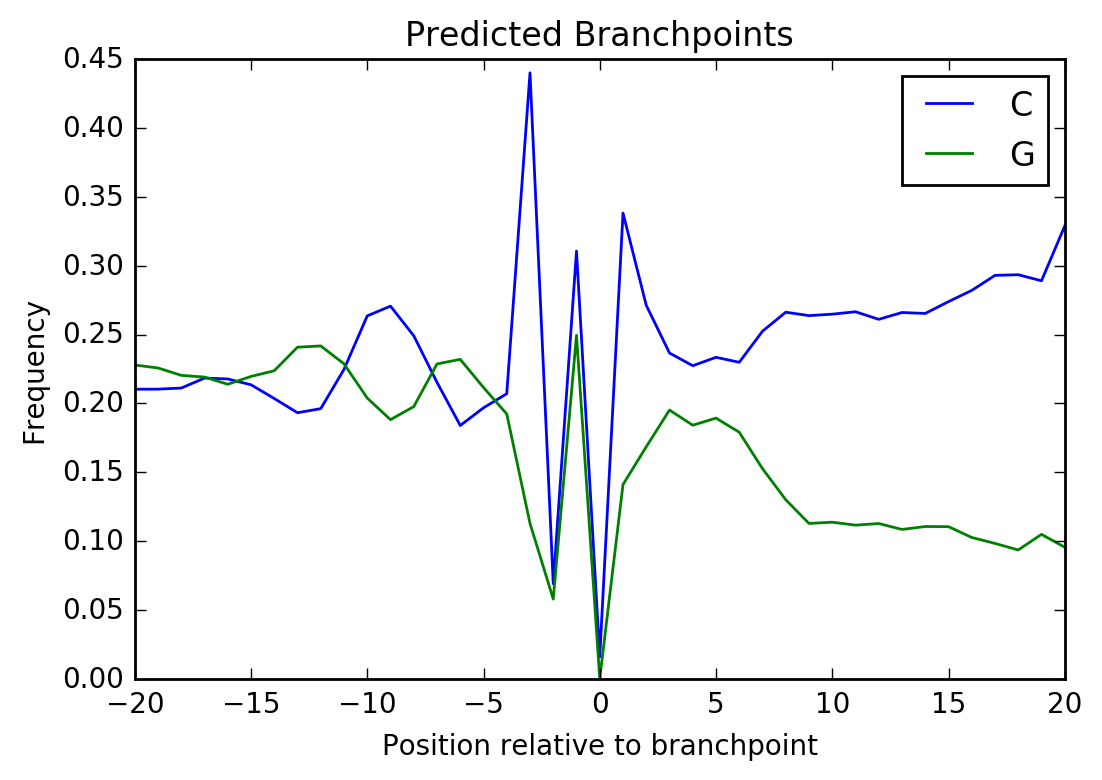

In [18]:
CCC = []
GGG = []
for i in range(41):
    CCC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1]*shuffle_bps[:, i+2, 1])]
    GGG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2]*shuffle_bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Shuffled Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(shuffle_bps[:, i, 1]*shuffle_bps[:, i+1, 1])]
    GG += [sum(shuffle_bps[:, i, 2]*shuffle_bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(shuffle_bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(shuffle_bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Shuffled Branchpoints')
plt.show()

CCC = []
GGG = []
for i in range(41):
    CCC += [sum(bps[:, i, 1]*bps[:, i+1, 1]*bps[:, i+2, 1])]
    GGG += [sum(bps[:, i, 2]*bps[:, i+1, 2]*bps[:, i+2, 2])]
plt.plot(range(-20, 21),
         np.array(CCC) / float(bps.shape[0]),
         label = 'CCC')
plt.plot(range(-20, 21),
         np.array(GGG) / float(bps.shape[0]),
         label = 'GGG')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.legend(loc = 'best')
plt.title('Predicted Branchpoints')
plt.show()
CC = []
GG = []
for i in range(41):
    CC += [sum(bps[:, i, 1]*bps[:, i+1, 1])]
    GG += [sum(bps[:, i, 2]*bps[:, i+1, 2])]
plt.plot(range(-20, 21),
         np.array(CC) / float(bps.shape[0]),
         label = 'CC')
plt.plot(range(-20, 21),
         np.array(GG) / float(bps.shape[0]),
         label = 'GG')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

C = []
G = []
for i in range(41):
    C += [sum(bps[:, i, 1])]
    G += [sum(bps[:, i, 2])]
plt.plot(range(-20, 21),
         np.array(C) / float(bps.shape[0]),
         label = 'C')
plt.plot(range(-20, 21),
         np.array(G) / float(bps.shape[0]),
         label = 'G')
plt.legend(loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('Position relative to branchpoint')
plt.title('Predicted Branchpoints')
plt.show()

17839


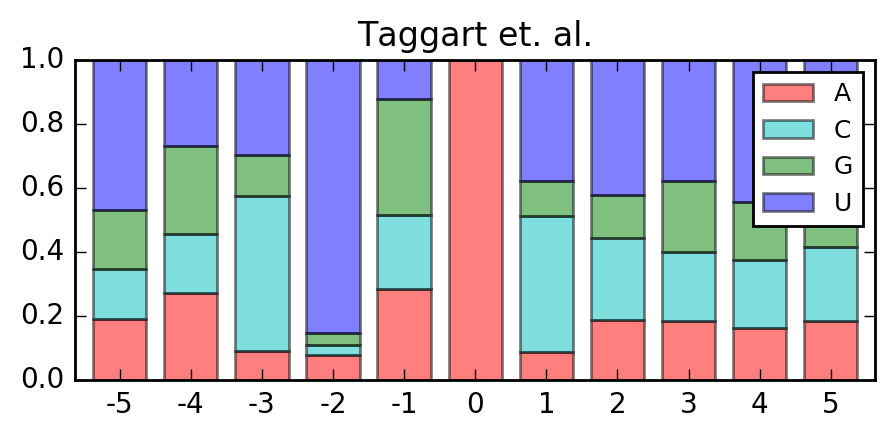

3808


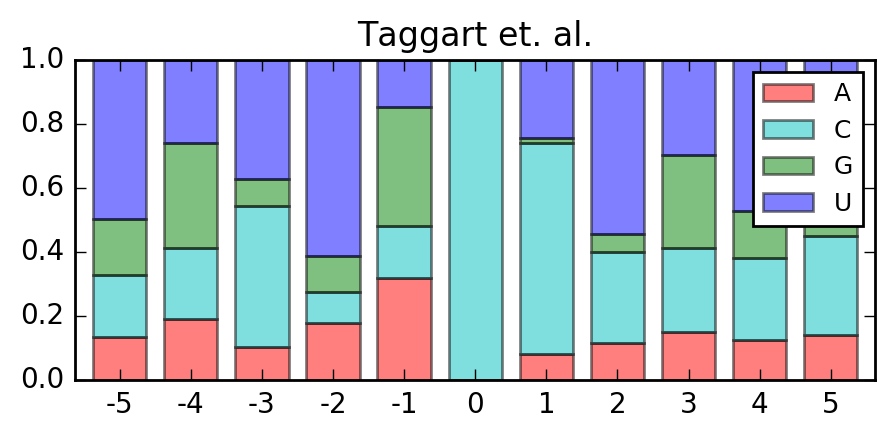

1068


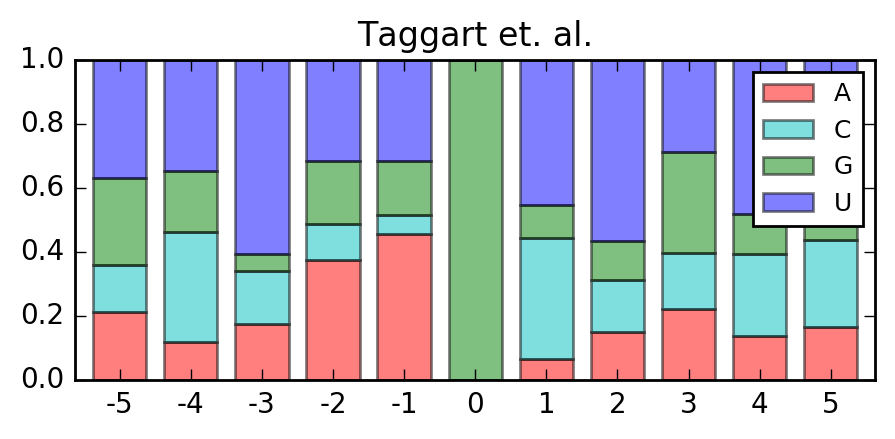

2609


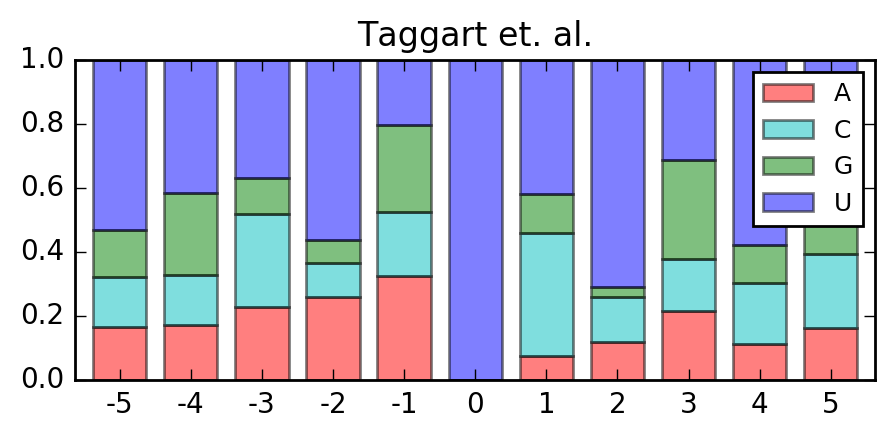

In [17]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_known, X_known):
        for bp in np.nonzero(target)[0]:
            if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
            if not seq[bp, i]: continue
            counts += seq[bp-K: bp+K+1, :4]
            total += 1
    print total
    pwm_logo(counts / total, 'Taggart et. al.')

202799


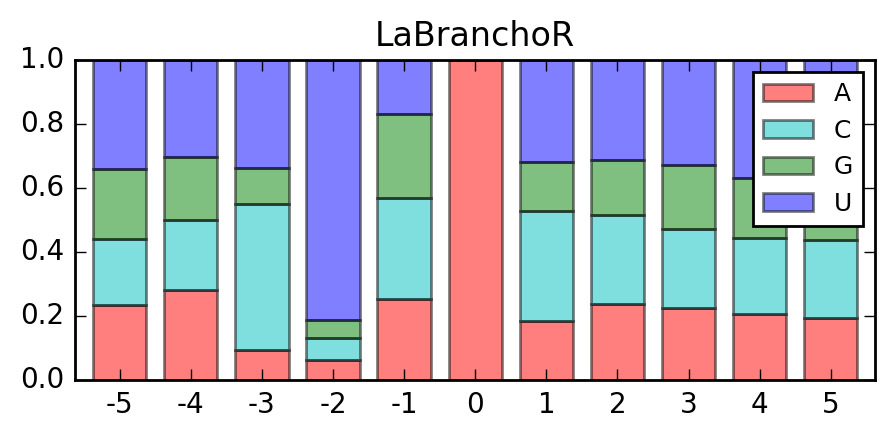

3351


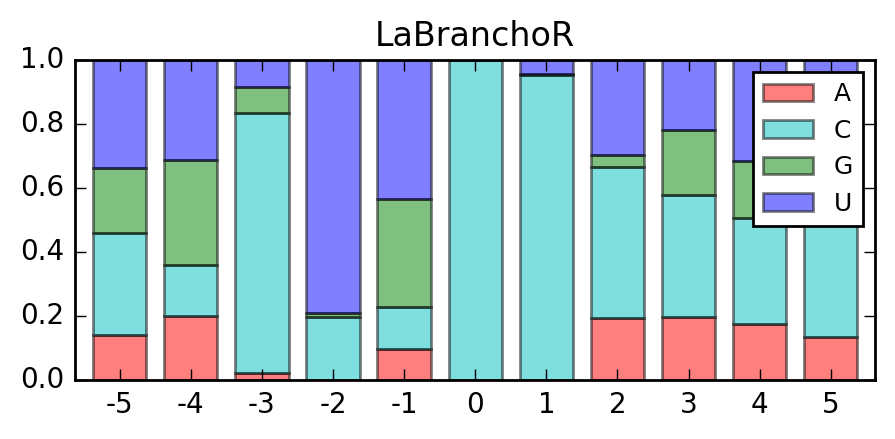

57


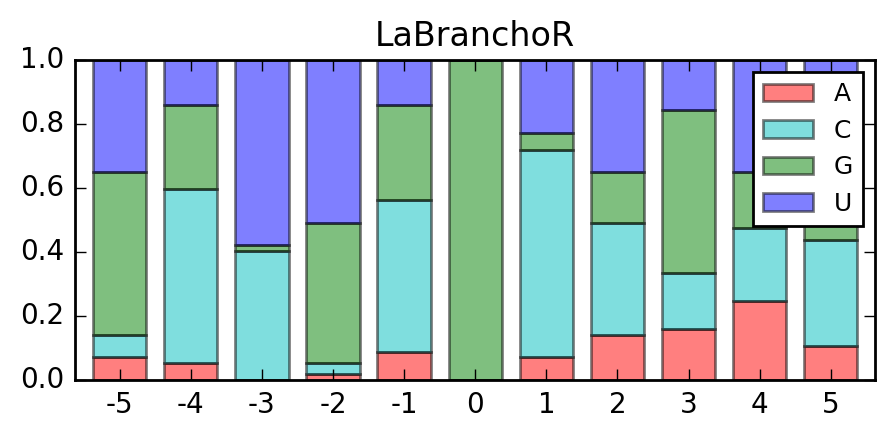

69


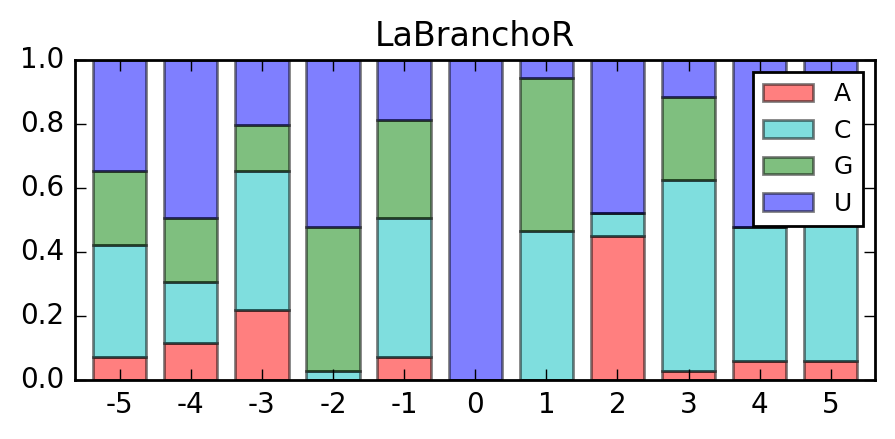

167355


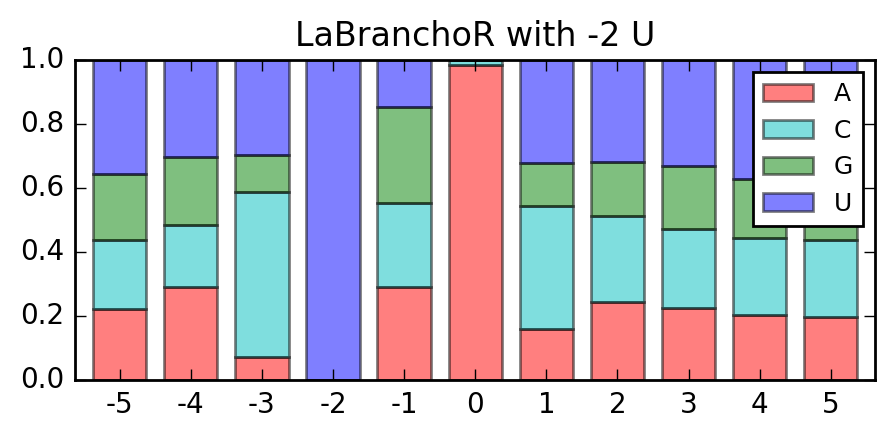

38921


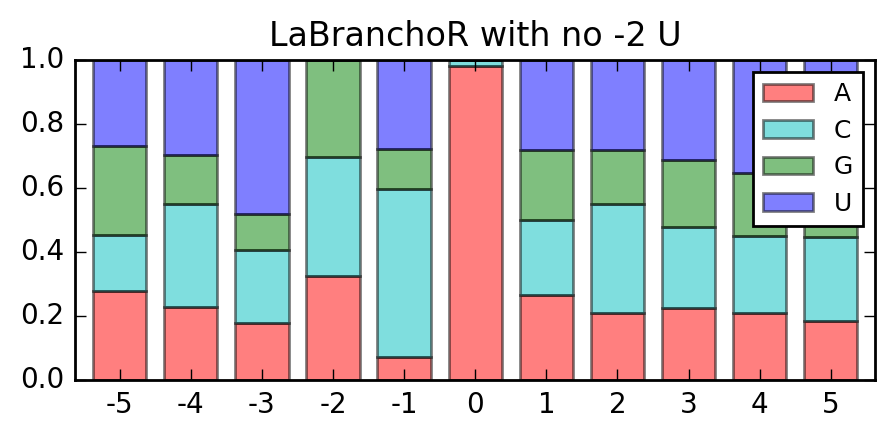

In [18]:
for i, base in enumerate(bases):
    K = 5
    counts = np.zeros((2*K+1, 4))
    total = 0
    for target, seq in zip(y_all, X_all):
        bp = np.argmax(target)
        if not seq[bp, i]: continue
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
    print total
    pwm_logo(counts / total, 'LaBranchoR')

# -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if not seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'LaBranchoR with -2 U')
# No -2 T
K = 5
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_all, X_all):
    bp = np.argmax(target)
    if seq[bp-2, 3]: continue
    if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
    counts = counts + seq[bp-K: bp+K+1, :4]
    total += 1
print total
pwm_logo(counts / total, 'LaBranchoR with no -2 U')

# Pathogenic Variants

In [21]:
# Make dict of chrom --> pos --> score
k_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, y_known):
    if chrom not in k_bps: k_bps[chrom] = {}
    for bp in np.nonzero(pred)[0]:
        idx = pos + (bp-L+1 if strand == '+' else L-bp)
        k_bps[chrom][idx] = strand
        
p_bps = {}
for chrom, pos, strand, pred in zip(k_chroms, k_coords,
                                    k_strands, p_known):
    if chrom not in p_bps: p_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    p_bps[chrom][idx] = strand
    
n_bps = {}
for chrom, pos, strand, pred in zip(n_chroms, n_coords,
                                    n_strands, y_novel):
    if chrom not in n_bps: n_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    n_bps[chrom][idx] = strand
    
a_bps = {}
for chrom, pos, strand, pred in zip(a_chroms, a_coords, a_strands, y_all):
    if chrom not in a_bps: a_bps[chrom] = {}
    bp = np.argmax(pred)
    idx = pos + (bp-L+1 if strand == '+' else L-bp)
    a_bps[chrom][idx] = strand

19813
3215
21186
Taggart et. al. branchpoints
187997	chr10	50681659	T	C	-1


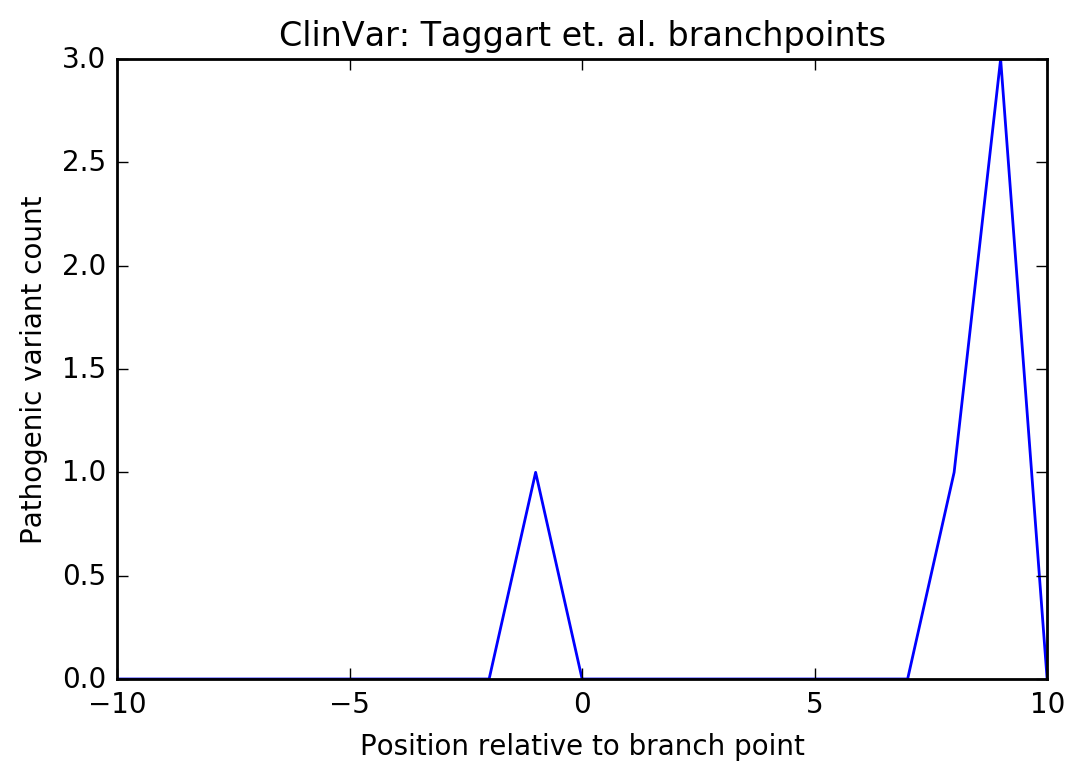

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 0.0
-4 0.0
-3 0.0
-2 0.0
-1 1.0
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 1.0
9 3.0
10 0.0
Predictions in Taggart introns


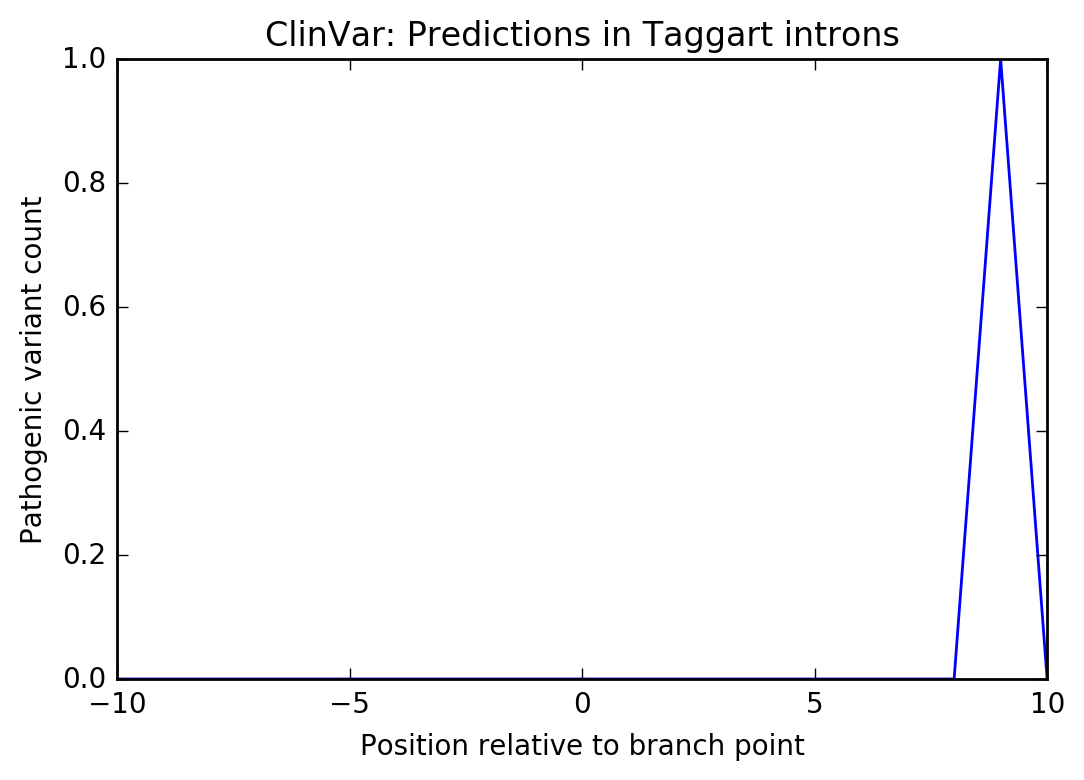

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 0.0
-4 0.0
-3 0.0
-2 0.0
-1 0.0
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 1.0
10 0.0
Novel predicted branchpoints
18060	chr11	108179837	A	G	-3
106395	chr2	225368567	A	C	-2
207862	chr11	2181258	C	T	-2
27370	chr11	2187017	A	T	-2
200318	chr17	7124242	G	A	-2
34160	chr1	156843392	T	A	-2
32227	chr9	137686903	T	G	-2
236732	chr3	3188088	T	C	-1
15300	chr3	14209904	T	C	0
205359	chrX	150572076	A	C,T	0
106394	chr2	225368565	T	C	0
21719	chr2	71817308	A	G	0
34417	chr1	197097820	T	C	0
26364	chrX	100601671	T	G	0
17355	chr11	64525847	T	C	0
23649	chr11	47359371	T	C	0
107169	chr2	189872759	A	G,T	0
44528	chr7	117251609	A	G	1
107018	chr2	189872760	G	T	1
361266	chrX	19369376	A	G	2
18713	chr16	67976512	A	G	3


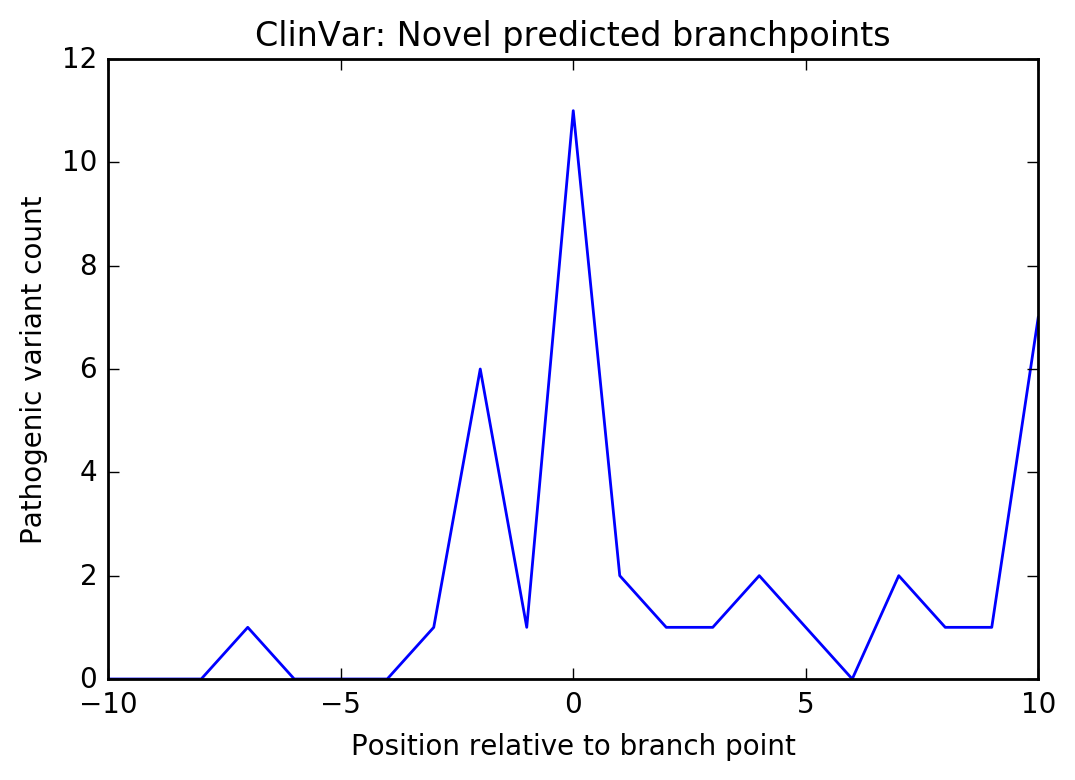

-10 0.0
-9 0.0
-8 0.0
-7 1.0
-6 0.0
-5 0.0
-4 0.0
-3 1.0
-2 6.0
-1 1.0
0 11.0
1 2.0
2 1.0
3 1.0
4 2.0
5 1.0
6 0.0
7 2.0
8 1.0
9 1.0
10 7.0
All predicted branchpoints
18060	chr11	108179837	A	G	-3
106395	chr2	225368567	A	C	-2
207862	chr11	2181258	C	T	-2
27370	chr11	2187017	A	T	-2
200318	chr17	7124242	G	A	-2
34160	chr1	156843392	T	A	-2
32227	chr9	137686903	T	G	-2
236732	chr3	3188088	T	C	-1
15300	chr3	14209904	T	C	0
205359	chrX	150572076	A	C,T	0
106394	chr2	225368565	T	C	0
21719	chr2	71817308	A	G	0
34417	chr1	197097820	T	C	0
26364	chrX	100601671	T	G	0
17355	chr11	64525847	T	C	0
23649	chr11	47359371	T	C	0
107169	chr2	189872759	A	G,T	0
44528	chr7	117251609	A	G	1
107018	chr2	189872760	G	T	1
361266	chrX	19369376	A	G	2
18713	chr16	67976512	A	G	3


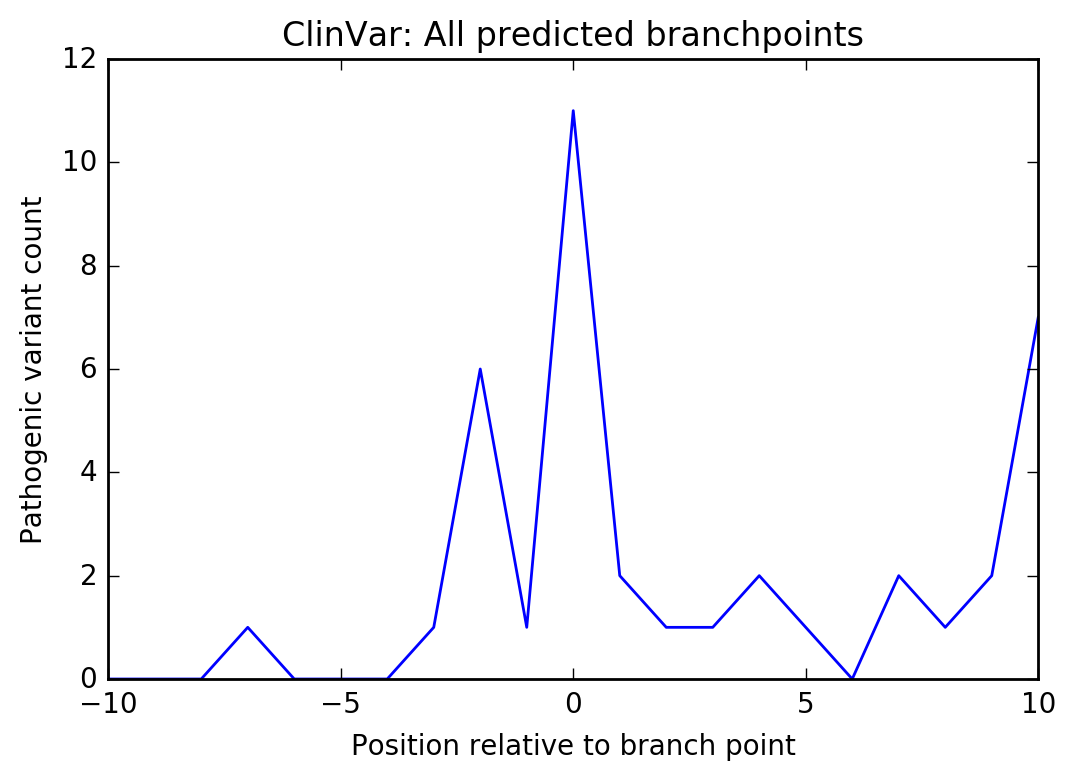

-10 0.0
-9 0.0
-8 0.0
-7 1.0
-6 0.0
-5 0.0
-4 0.0
-3 1.0
-2 6.0
-1 1.0
0 11.0
1 2.0
2 1.0
3 1.0
4 2.0
5 1.0
6 0.0
7 2.0
8 1.0
9 2.0
10 7.0


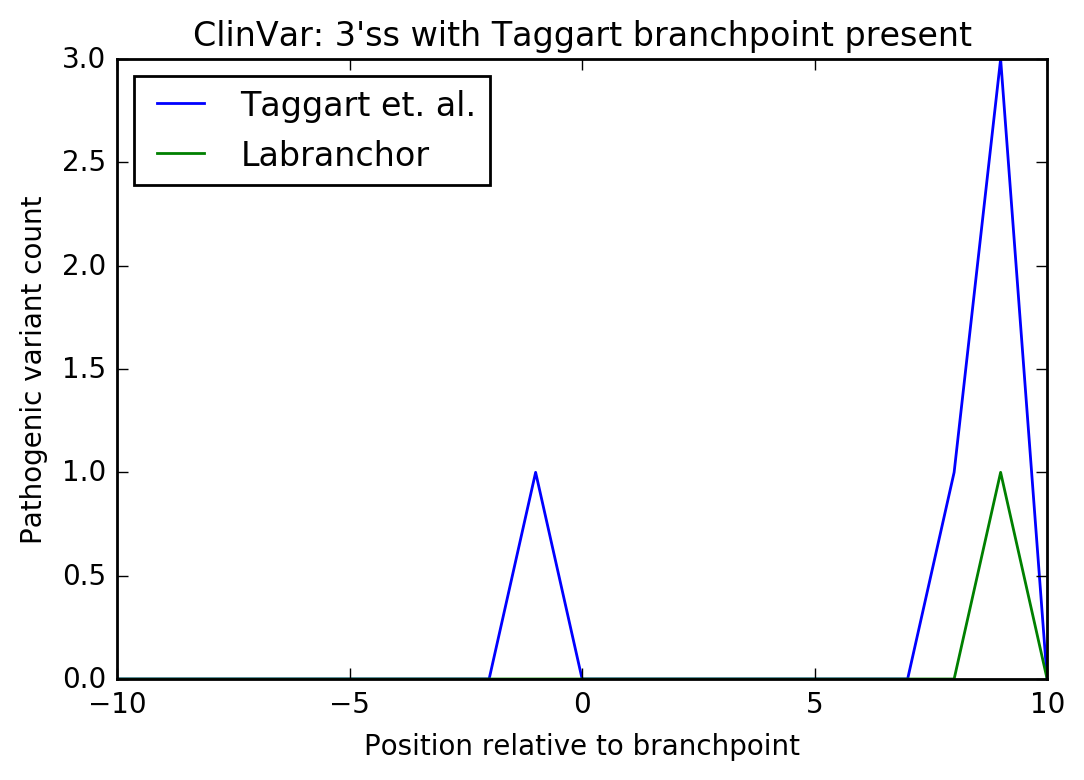

Taggart et. al. branchpoints
CS163247	-4
CS094606	-2
CS099993	-1
CS061318	0
CD012541	0
CS032696	0
CD041169	2
CS154981	3
CS104063	3


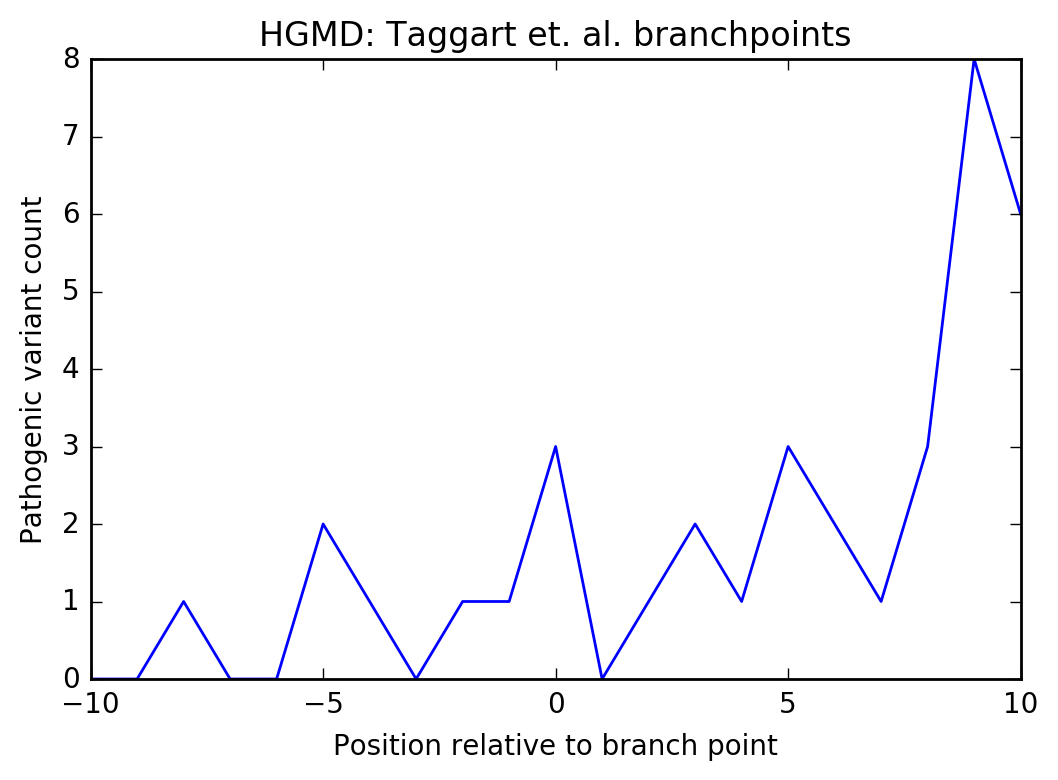

-10 0.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 2.0
-4 1.0
-3 0.0
-2 1.0
-1 1.0
0 3.0
1 0.0
2 1.0
3 2.0
4 1.0
5 3.0
6 2.0
7 1.0
8 3.0
9 8.0
10 6.0
Predictions in Taggart introns
CS991418	-4
CD061423	-4
CS163247	-3
CX162425	-2
CS061318	0
CD012541	0
CS991417	0
CS032696	0
CD041169	0
CS1615967	1
CS151592	2
CS104063	3


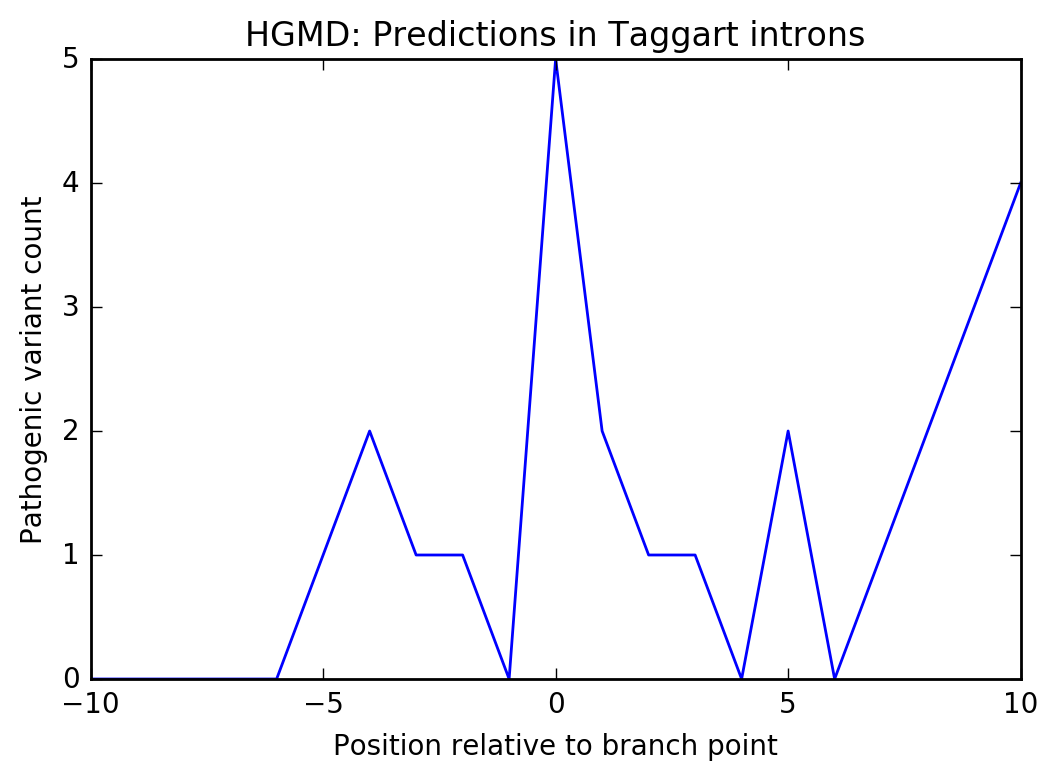

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 1.0
-4 2.0
-3 1.0
-2 1.0
-1 0.0
0 5.0
1 2.0
2 1.0
3 1.0
4 0.0
5 2.0
6 0.0
7 1.0
8 2.0
9 3.0
10 4.0
Novel predicted branchpoints
CS123561	-4
CS984089	-3
CX124736	-3
CS113461	-3
CS100777	-3
CS961478	-3
CS003079	-2
CS102107	-2
CS152784	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CD961740	-2
CS120217	-2
CS992243	-2
CS051251	-2
CS982129	-2
CS120706	-2
CS000224	-2
CS106163	-2
CS991465	-1
CS086376	-1
CS160300	-1
CS166863	-1
CS061319	0
CS0911057	0
CS0911056	0
CS134807	0
CS115634	0
CS961496	0
CS070412	0
CS971815	0
CS050424	0
CS091963	0
CS040564	0
CS992727	0
CS127946	0
CS109543	0
CS080674	0
CS164296	0
CS1411892	0
CS083264	0
CS1510152	0
CS982093	0
CS092160	0
CS1010416	0
CS050824	0
CS120705	0
CS092987	0
CS961698	0
CS061275	0
CS054888	0
CS094363	0
CS1412732	0
CS102223	0
CS094892	0
CS072199	0
CS982186	0
CS143829	0
CD992500	0
CR138585	0
CS1615634	0
CD0911062	1
CS129642	1
CD097729	1
CS050111	1
CS135498	1
CS971738	1
CS1310520	1
CS167573	1
CS920740	1
CD962112	1
CS14127

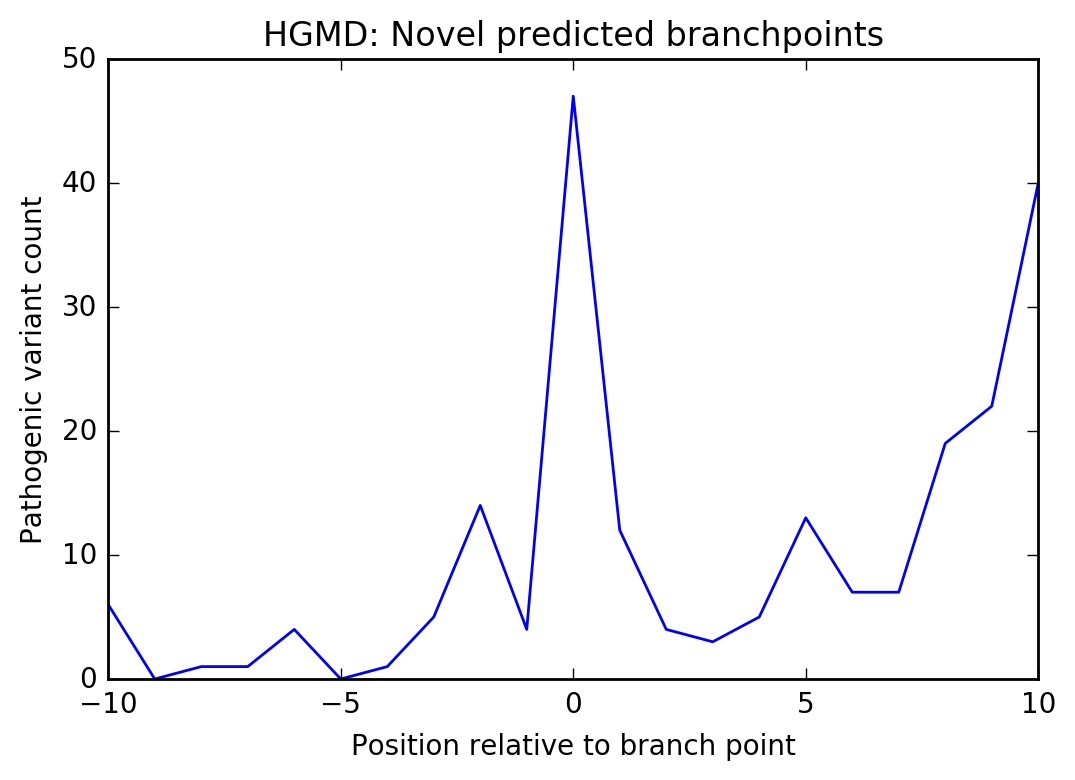

-10 6.0
-9 0.0
-8 1.0
-7 1.0
-6 4.0
-5 0.0
-4 1.0
-3 5.0
-2 14.0
-1 4.0
0 47.0
1 12.0
2 4.0
3 3.0
4 5.0
5 13.0
6 7.0
7 7.0
8 19.0
9 22.0
10 40.0
All predicted branchpoints
CS991418	-4
CS123561	-4
CD061423	-4
CX124736	-3
CS163247	-3
CS984089	-3
CS113461	-3
CS100777	-3
CS961478	-3
CS003079	-2
CS102107	-2
CS152784	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CD961740	-2
CS120217	-2
CS992243	-2
CS051251	-2
CS982129	-2
CS120706	-2
CX162425	-2
CS000224	-2
CS106163	-2
CS991465	-1
CS086376	-1
CS160300	-1
CS166863	-1
CS061319	0
CS061318	0
CS0911057	0
CS0911056	0
CS971815	0
CS134807	0
CS115634	0
CS961496	0
CS070412	0
CS991417	0
CS032696	0
CS040564	0
CS050424	0
CS091963	0
CD012541	0
CS992727	0
CS127946	0
CS109543	0
CS080674	0
CS164296	0
CS1411892	0
CS083264	0
CS1510152	0
CS982093	0
CS092160	0
CS1010416	0
CS050824	0
CS120705	0
CS092987	0
CD041169	0
CS961698	0
CS061275	0
CS054888	0
CS094363	0
CS1412732	0
CS102223	0
CS094892	0
CS072199	0
CS982186	0
CS143829	0
CD992500	0
CR138585	0
CS1615634	0
CD0911062	1

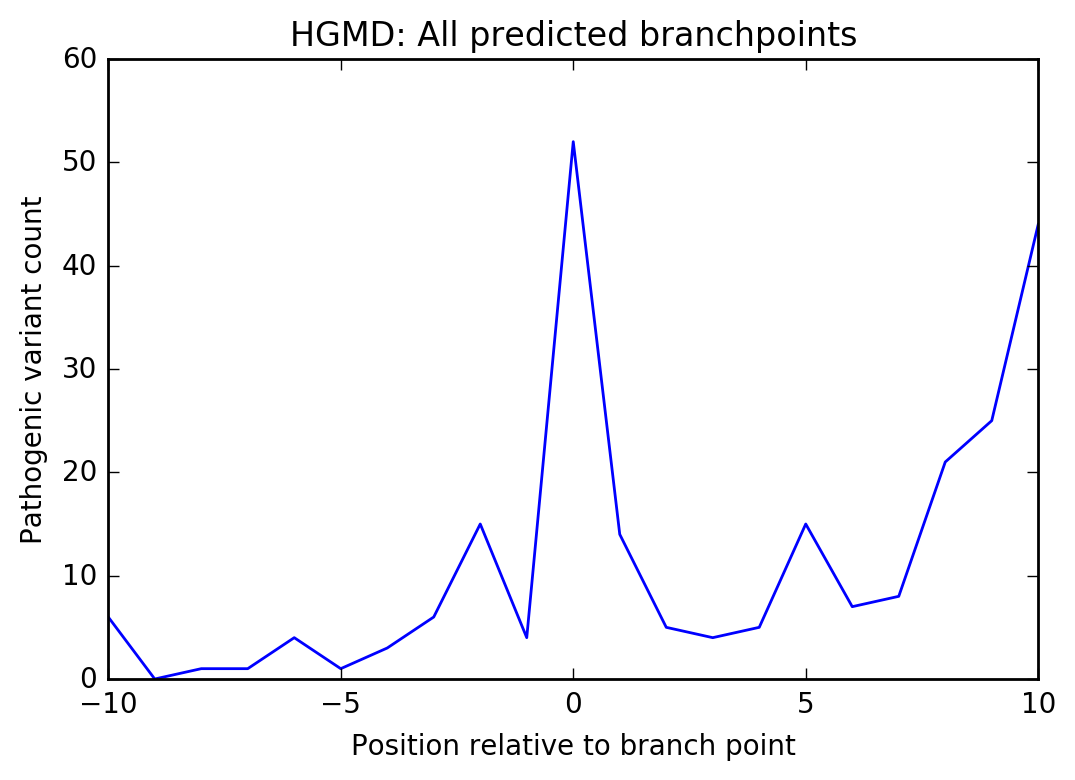

-10 6.0
-9 0.0
-8 1.0
-7 1.0
-6 4.0
-5 1.0
-4 3.0
-3 6.0
-2 15.0
-1 4.0
0 52.0
1 14.0
2 5.0
3 4.0
4 5.0
5 15.0
6 7.0
7 8.0
8 21.0
9 25.0
10 44.0


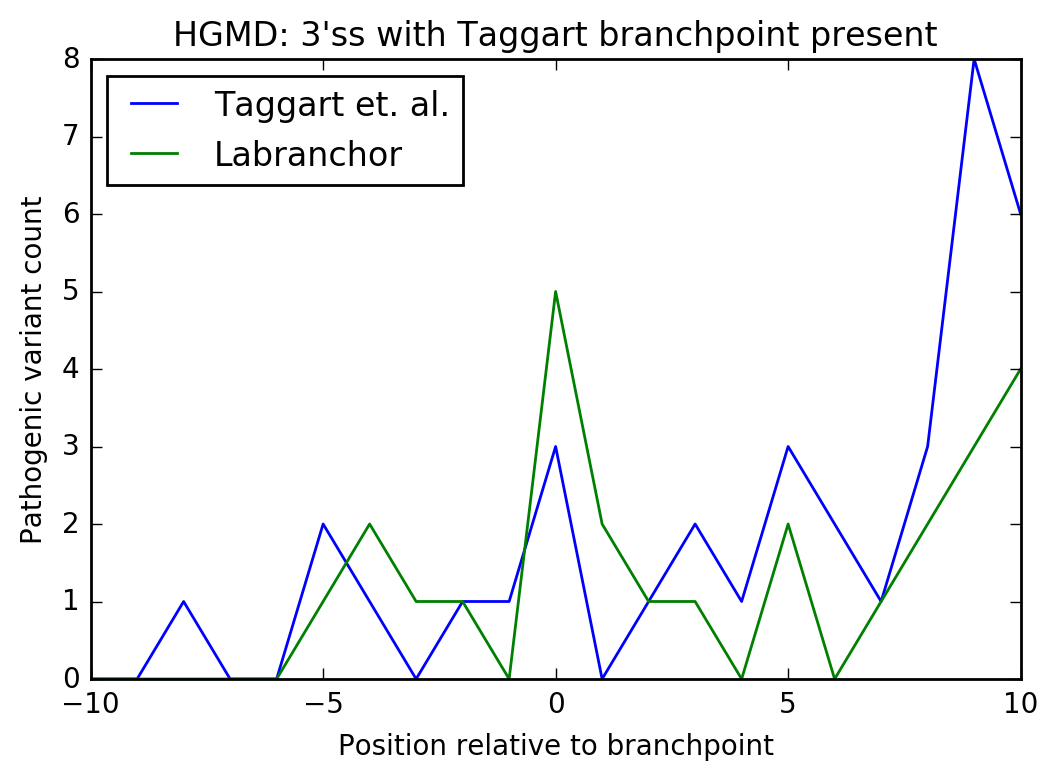

Taggart et. al. branchpoints
CS163247	-4
CS094606	-2
187997	-1
CS061318	0
CD012541	0
CS032696	0
CD041169	2
CS154981	3
CS104063	3


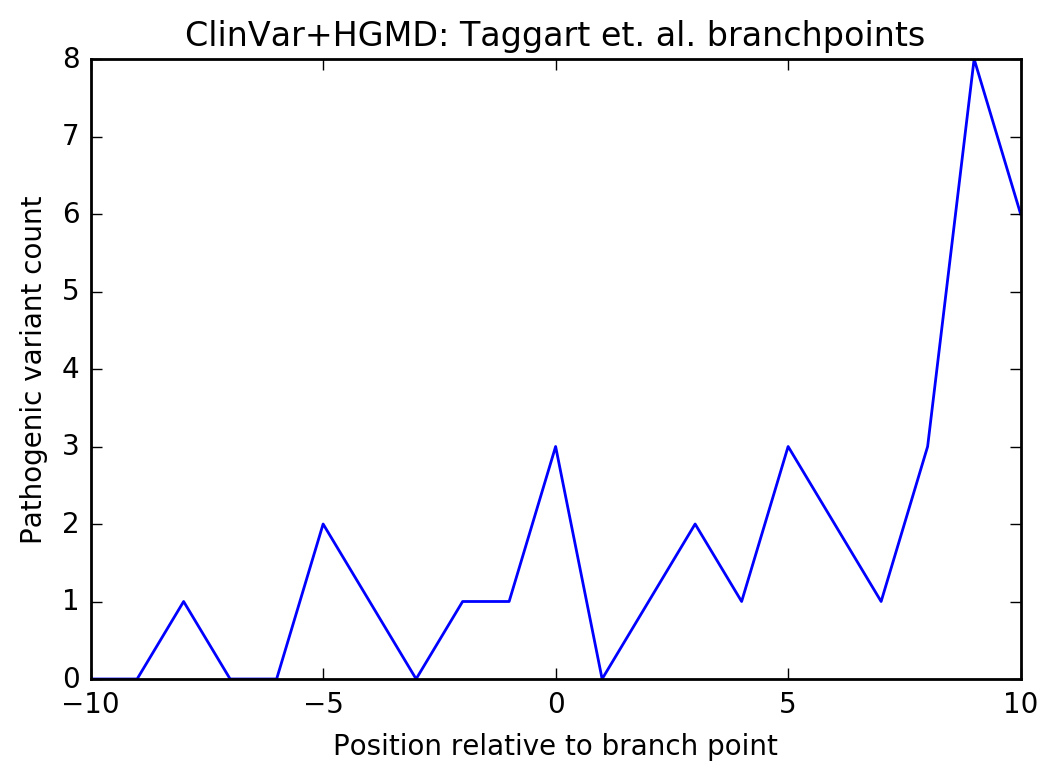

-10 0.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 2.0
-4 1.0
-3 0.0
-2 1.0
-1 1.0
0 3.0
1 0.0
2 1.0
3 2.0
4 1.0
5 3.0
6 2.0
7 1.0
8 3.0
9 8.0
10 6.0
Predictions in Taggart introns
CS991418	-4
CD061423	-4
CS163247	-3
CX162425	-2
CS061318	0
CD012541	0
CS991417	0
CS032696	0
CD041169	0
CS1615967	1
CS151592	2
CS104063	3


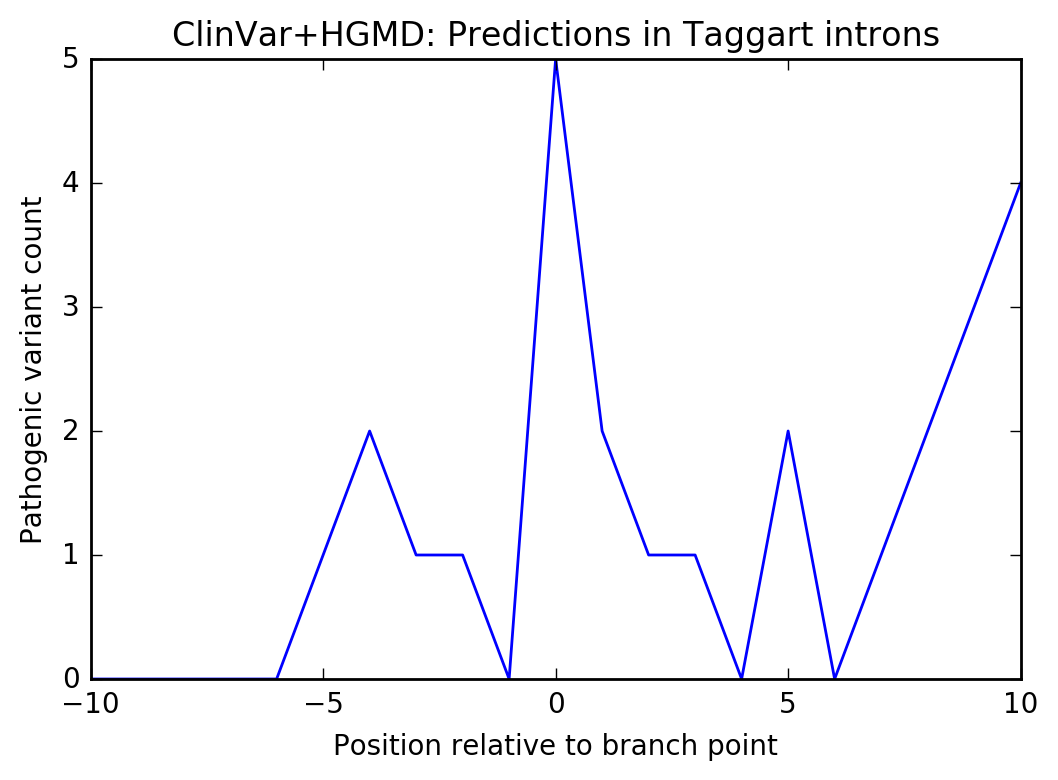

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 1.0
-4 2.0
-3 1.0
-2 1.0
-1 0.0
0 5.0
1 2.0
2 1.0
3 1.0
4 0.0
5 2.0
6 0.0
7 1.0
8 2.0
9 3.0
10 4.0
Novel predicted branchpoints
CS123561	-4
CS984089	-3
CX124736	-3
CS113461	-3
18060	-3
CD961740	-3
CS100777	-3
207862	-2
CS102107	-2
CS152784	-2
27370	-2
CS952206	-2
CS971736	-2
32227	-2
CS1614900	-2
CS992243	-2
34160	-2
CS051251	-2
200318	-2
106395	-2
CS106163	-2
CS991465	-1
CS086376	-1
236732	-1
CS166863	-1
34417	0
CS061319	0
107169	0
205359	0
CS0911057	0
CS0911056	0
CS134807	0
CS115634	0
CS961496	0
CS070412	0
CS050424	0
CS992727	0
CS127946	0
CS109543	0
CS080674	0
CS164296	0
CS1411892	0
CS083264	0
CS1510152	0
CS982093	0
CS1010416	0
23649	0
17355	0
CS961698	0
CS054888	0
CS094363	0
106394	0
15300	0
CS102223	0
CS094892	0
CS072199	0
CS982186	0
21719	0
26364	0
CS143829	0
CD992500	0
CR138585	0
CS1615634	0
CD0911062	1
107018	1
CS129642	1
CD097729	1
CS050111	1
CS135498	1
CS971738	1
CS1310520	1
CS167573	1
CD962112	1
CS159214	1
44528	1
CR962650	2
361266	2
CX0

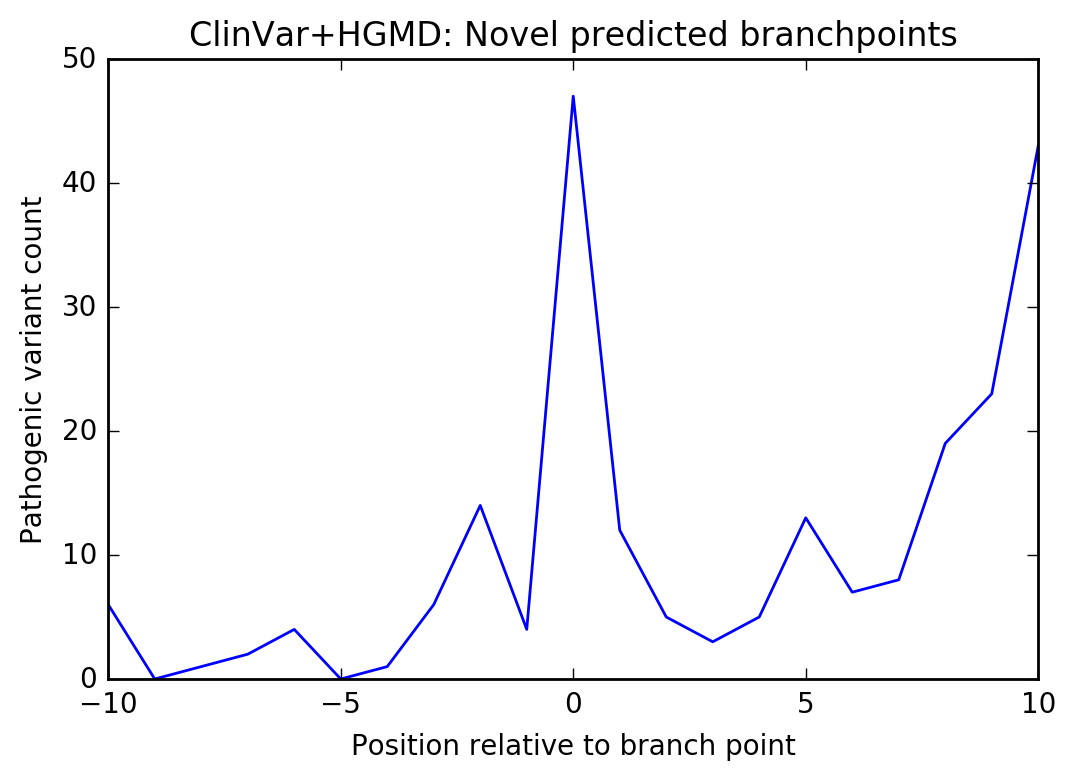

-10 6.0
-9 0.0
-8 1.0
-7 2.0
-6 4.0
-5 0.0
-4 1.0
-3 6.0
-2 14.0
-1 4.0
0 47.0
1 12.0
2 5.0
3 3.0
4 5.0
5 13.0
6 7.0
7 8.0
8 19.0
9 23.0
10 43.0
All predicted branchpoints
CS991418	-4
CS123561	-4
CD061423	-4
CX124736	-3
CS163247	-3
CS984089	-3
CS113461	-3
18060	-3
CD961740	-3
CS100777	-3
207862	-2
CS102107	-2
CS152784	-2
27370	-2
CS952206	-2
CS971736	-2
32227	-2
CS1614900	-2
CS992243	-2
34160	-2
CS051251	-2
200318	-2
CX162425	-2
106395	-2
CS106163	-2
CS991465	-1
CS086376	-1
236732	-1
CS166863	-1
34417	0
CS061319	0
CS061318	0
107169	0
205359	0
CS0911057	0
CS0911056	0
CS134807	0
CS115634	0
CS961496	0
CS070412	0
CS991417	0
CS032696	0
CS050424	0
CD012541	0
CS992727	0
CS127946	0
CS109543	0
CS080674	0
CS164296	0
CS1411892	0
CS083264	0
CS1510152	0
CS982093	0
CS1010416	0
23649	0
17355	0
CD041169	0
CS961698	0
CS054888	0
CS094363	0
106394	0
15300	0
CS102223	0
CS094892	0
CS072199	0
CS982186	0
21719	0
26364	0
CS143829	0
CD992500	0
CR138585	0
CS1615634	0
CD0911062	1
107018	1
CS1615967	1
CS129642	1


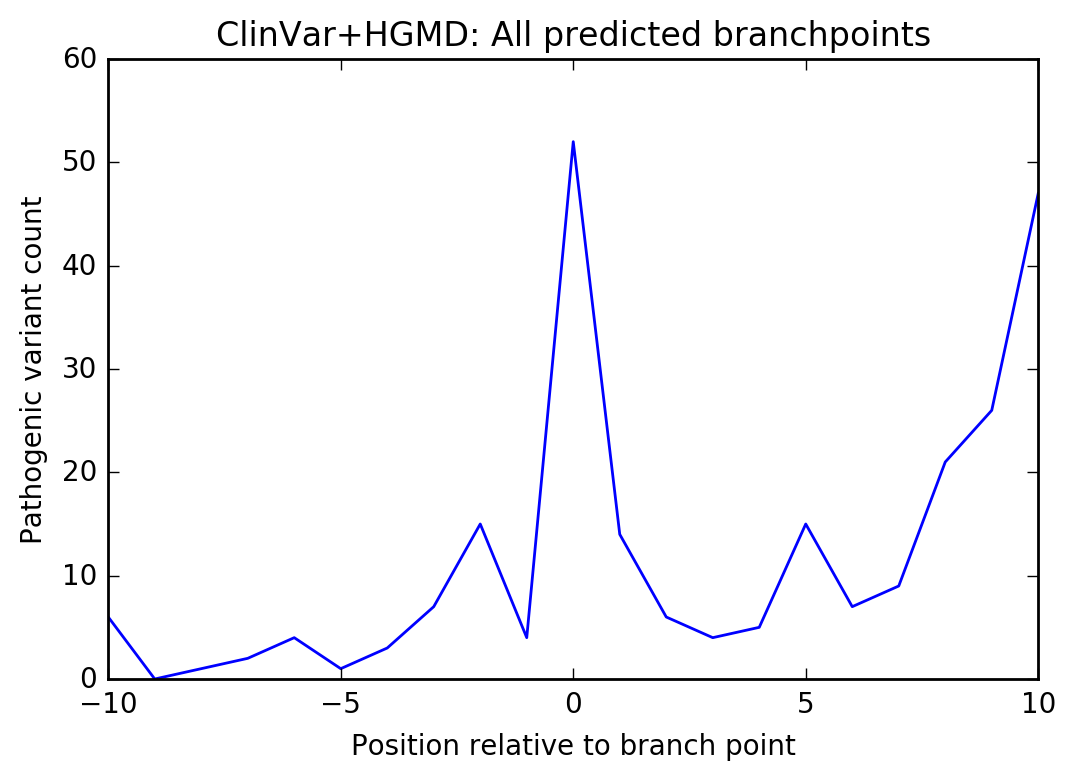

-10 6.0
-9 0.0
-8 1.0
-7 2.0
-6 4.0
-5 1.0
-4 3.0
-3 7.0
-2 15.0
-1 4.0
0 52.0
1 14.0
2 6.0
3 4.0
4 5.0
5 15.0
6 7.0
7 9.0
8 21.0
9 26.0
10 47.0


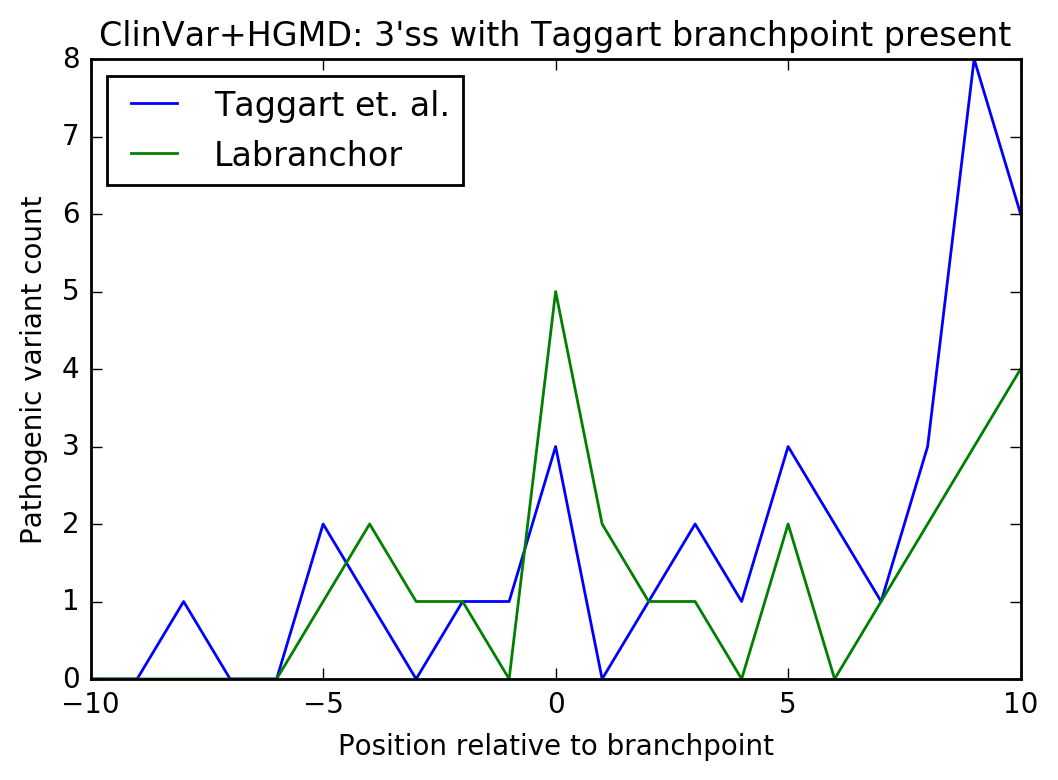

In [24]:
def var_enrichment(v, bps, write, K = 10):
    hits = np.zeros((2*K+1,))
    variants = {}
    for shift in range(-K, K+1):
        for chrom, pos, ID, ref, alt in v:
            if chrom not in bps: continue
            if write:
                ID = '\t'.join([ID, chrom, str(pos), ref, alt])
            if ID in variants and abs(variants[ID]) < abs(shift): continue
            if ((pos-shift in bps[chrom])
                 and (bps[chrom][pos-shift] == '+')):
                hits[K+shift] += len(alt.split(','))
                if ID in variants:
                    hits[K+variants[ID]] -= len(ID.split('\t')[-1].split(','))
                variants[ID] = shift
            
            if ((pos+shift in bps[chrom])
                and (bps[chrom][pos+shift] == '-')):
                hits[K+shift] += len(alt.split(','))
                if ID in variants:
                    hits[K+variants[ID]] -= len(ID.split('\t')[-1].split(','))
                variants[ID] = shift
    for ID, shift in sorted(variants.items(), key=lambda x: x[1]):
        if -5 < shift < 4:
            print ID+'\t'+str(shift)
    return hits

effects = ['stoploss', 'stopgain', 'nonsynonymous', 'frameshift']
hgmd = []
with open('../anno/hgmd2017.se.vcf') as fp:
    for line in fp:
        if line[0] == '#':
            continue
        chrom, pos, ID, ref, alt, qual, filt, info = line.strip().split()
        if any(effect in info for effect in effects): continue
        for i in range(len(ref)):
            hgmd += [('chr'+chrom, int(pos)+i, ID, ref, alt)]

clinvar = []
with open('../anno/clinvar.se.vcf') as fp:
    for line in fp:
        if line[0] == '#':
            continue
        chrom, pos, ID, ref, alt, qual, filt, info = line.strip().split()
        
        if any(effect in info for effect in effects): continue
        
        for i in range(len(ref)):
            clinvar += [('chr'+chrom, int(pos)+i, ID, ref, alt)]

clinvar_idx = set()
for chrom, start, rs, ref, alt in clinvar:
    clinvar_idx.add((chrom, start, alt))
clin_hgmd = [item for item in clinvar]
for chrom, start, rs, ref, alt in hgmd:
    if (chrom, start, alt) not in clinvar_idx:
        clin_hgmd += [(chrom, start, rs, ref, alt)]

print len(hgmd)    
print len(clinvar)
print len(clin_hgmd)

names = ['Taggart et. al. branchpoints',
         'Predictions in Taggart introns',
         'Novel predicted branchpoints',
         'All predicted branchpoints']
bps = [k_bps, p_bps, n_bps, a_bps]

for v, title in zip([clinvar, hgmd, clin_hgmd],
                    ['ClinVar', 'HGMD', 'ClinVar+HGMD']):
    path = []
    for bp, name in zip(bps, names):
        print name
        path += [var_enrichment(v, bp, title == 'ClinVar')]
        plt.plot(range(-10, 11), path[-1])
        plt.title("{}: {}".format(title, name))
        plt.xlabel('Position relative to branch point')
        plt.ylabel("Pathogenic variant count")
        plt.show()
        for i, c in zip(range(-10, 11), path[-1]):
            print i, c
    
    for name, hits in zip(['Taggart et. al.', 'Labranchor'], path)[:2]:
        plt.plot(range(-10, 11), hits, label = name)
    plt.title("{}: 3'ss with Taggart branchpoint present".format(title))
    plt.xlabel('Position relative to branchpoint')
    plt.ylabel("Pathogenic variant count")
    plt.legend(loc = 2)
    plt.show()

234037
24659
240438
Taggart et. al. branchpoints
187997	chr10	50681659	T	C	-1


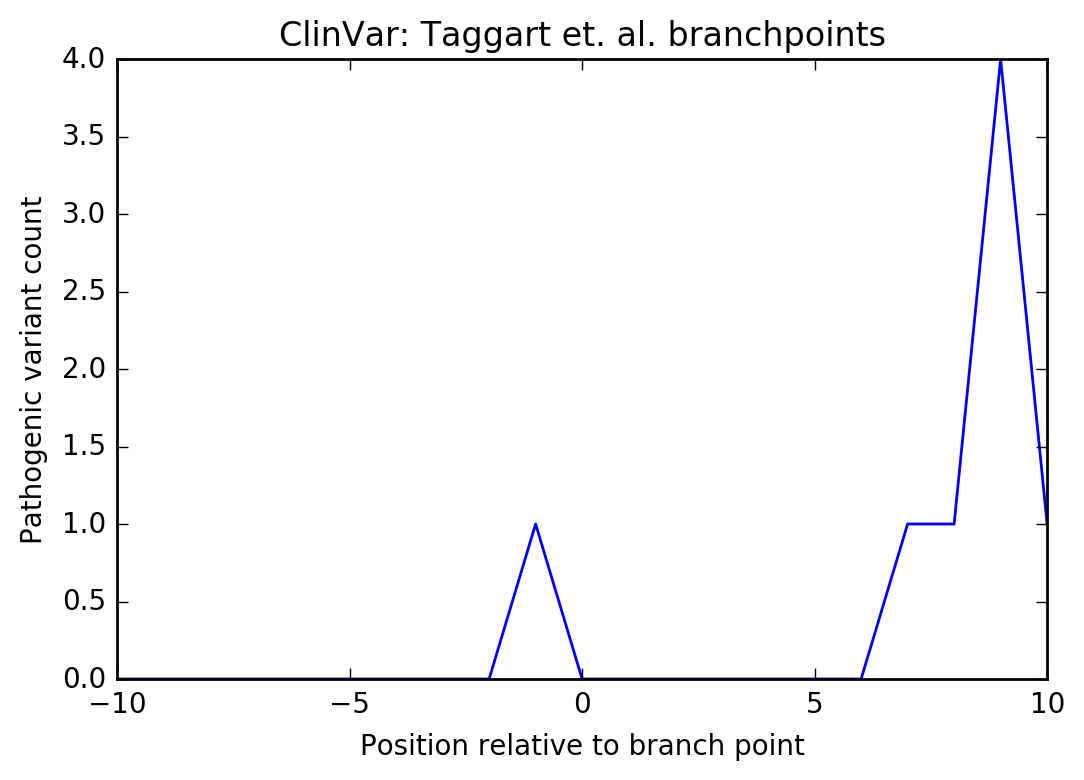

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 0.0
-4 0.0
-3 0.0
-2 0.0
-1 1.0
0 0.0
1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 1.0
8 1.0
9 4.0
10 1.0
Predictions in Taggart introns


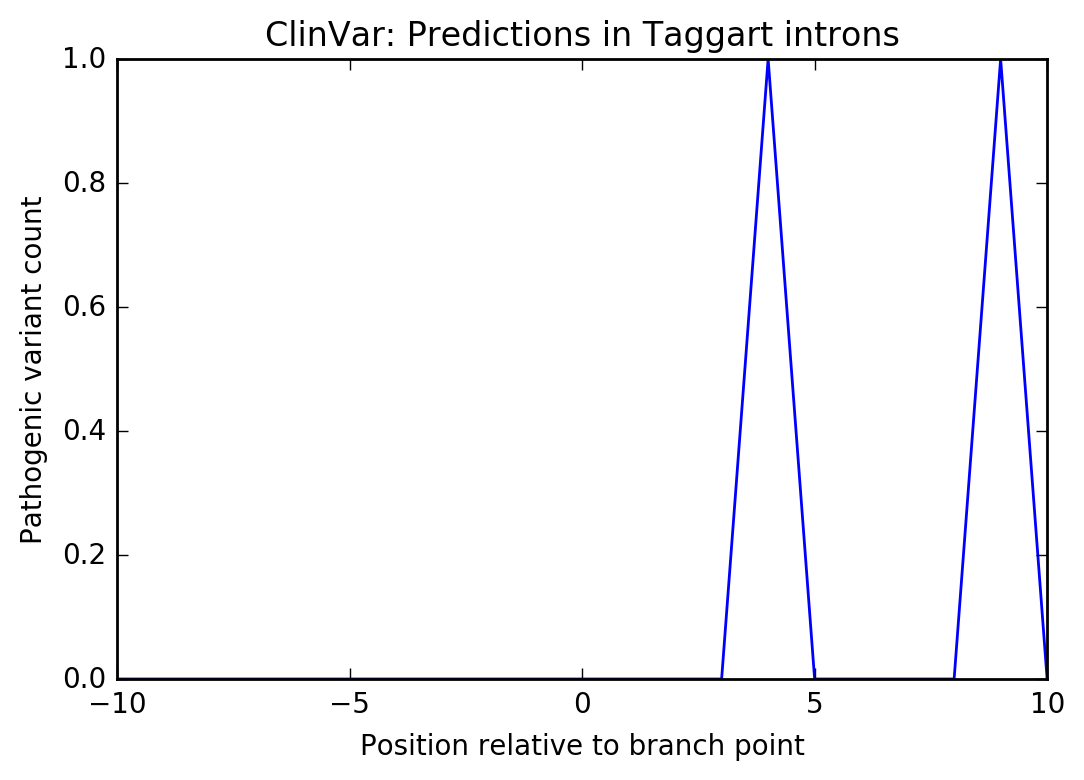

-10 0.0
-9 0.0
-8 0.0
-7 0.0
-6 0.0
-5 0.0
-4 0.0
-3 0.0
-2 0.0
-1 0.0
0 0.0
1 0.0
2 0.0
3 0.0
4 1.0
5 0.0
6 0.0
7 0.0
8 0.0
9 1.0
10 0.0
Novel predicted branchpoints
96137	chr2	47630472	G	T	-4
29430	chr2	48915301	G	T	-4
59489	chrX	48762195	C	T	-3
18060	chr11	108179837	A	G	-3
33424	chr2	175619033	C	G	-3
153827	chr6	53156606	G	C	-3
207862	chr11	2181258	C	T	-2
106395	chr2	225368567	A	C	-2
169295	chr16	57693480	T	C	-2
27370	chr11	2187017	A	T	-2
200318	chr17	7124242	G	A	-2
34160	chr1	156843392	T	A	-2
32227	chr9	137686903	T	G	-2
39097	chr11	75277627	T	C	-1
236732	chr3	3188088	T	C	-1
205359	chrX	150572076	A	C,T	0
106394	chr2	225368565	T	C	0
21719	chr2	71817308	A	G	0
34417	chr1	197097820	T	C	0
26364	chrX	100601671	T	G	0
17355	chr11	64525847	T	C	0
23649	chr11	47359371	T	C	0
15300	chr3	14209904	T	C	0
107169	chr2	189872759	A	G,T	0
44528	chr7	117251609	A	G	1
107018	chr2	189872760	G	T	1
29433	chr2	48915743	A	G	1
260165	chr17	39768562	G	C	2
153342	chrX	153296756	T	A	2
361266	chrX	19369376	A	G	2
187

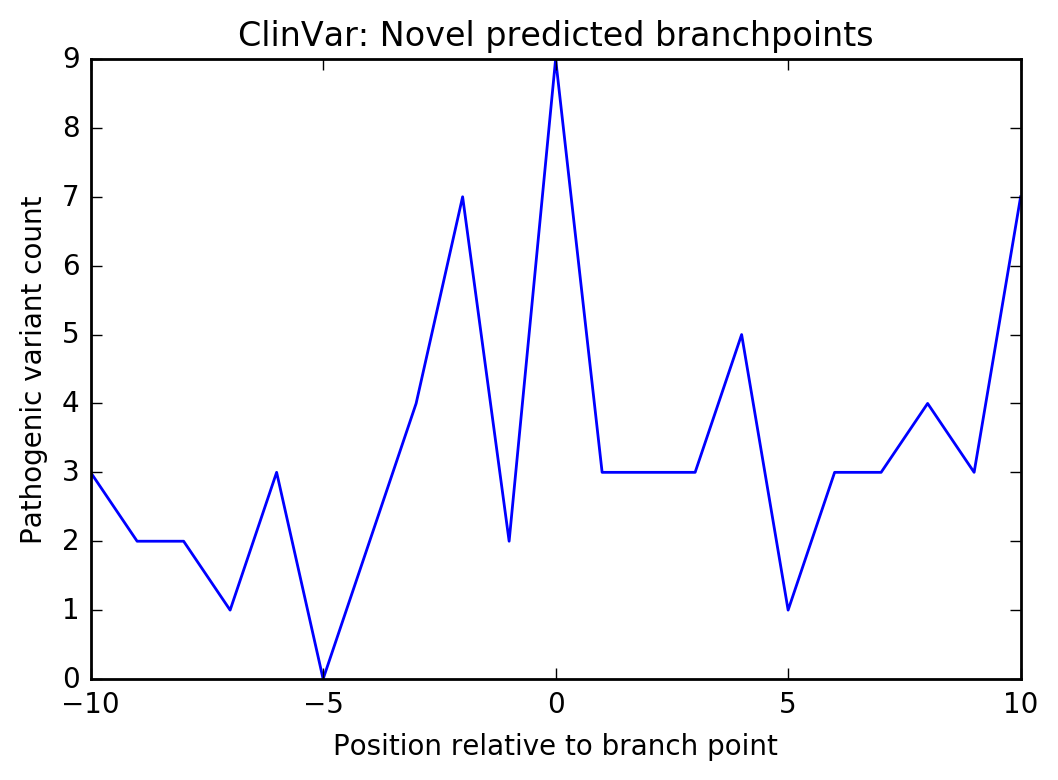

-10 3.0
-9 2.0
-8 2.0
-7 1.0
-6 3.0
-5 0.0
-4 2.0
-3 4.0
-2 7.0
-1 2.0
0 9.0
1 3.0
2 3.0
3 3.0
4 5.0
5 1.0
6 3.0
7 3.0
8 4.0
9 3.0
10 7.0
All predicted branchpoints
96137	chr2	47630472	G	T	-4
29430	chr2	48915301	G	T	-4
59489	chrX	48762195	C	T	-3
18060	chr11	108179837	A	G	-3
33424	chr2	175619033	C	G	-3
153827	chr6	53156606	G	C	-3
207862	chr11	2181258	C	T	-2
106395	chr2	225368567	A	C	-2
169295	chr16	57693480	T	C	-2
27370	chr11	2187017	A	T	-2
200318	chr17	7124242	G	A	-2
34160	chr1	156843392	T	A	-2
32227	chr9	137686903	T	G	-2
39097	chr11	75277627	T	C	-1
236732	chr3	3188088	T	C	-1
205359	chrX	150572076	A	C,T	0
106394	chr2	225368565	T	C	0
21719	chr2	71817308	A	G	0
34417	chr1	197097820	T	C	0
26364	chrX	100601671	T	G	0
17355	chr11	64525847	T	C	0
23649	chr11	47359371	T	C	0
15300	chr3	14209904	T	C	0
107169	chr2	189872759	A	G,T	0
44528	chr7	117251609	A	G	1
107018	chr2	189872760	G	T	1
29433	chr2	48915743	A	G	1
260165	chr17	39768562	G	C	2
153342	chrX	153296756	T	A	2
361266	chrX	19369376	A	G	2
18713

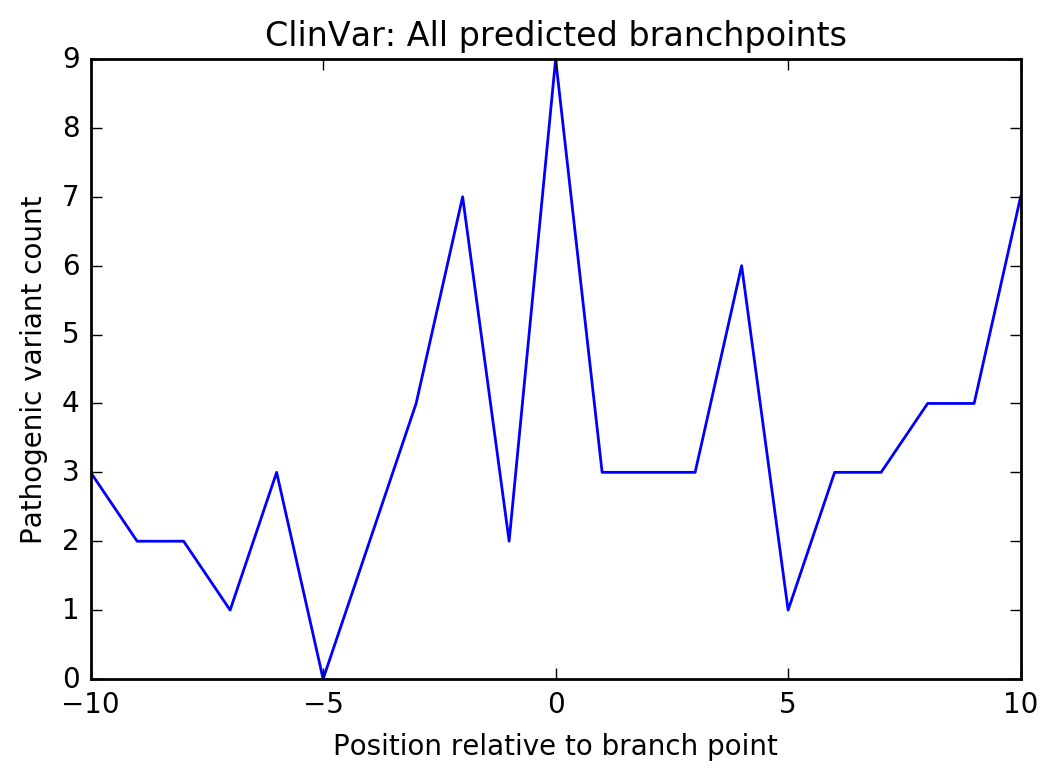

-10 3.0
-9 2.0
-8 2.0
-7 1.0
-6 3.0
-5 0.0
-4 2.0
-3 4.0
-2 7.0
-1 2.0
0 9.0
1 3.0
2 3.0
3 3.0
4 6.0
5 1.0
6 3.0
7 3.0
8 4.0
9 4.0
10 7.0


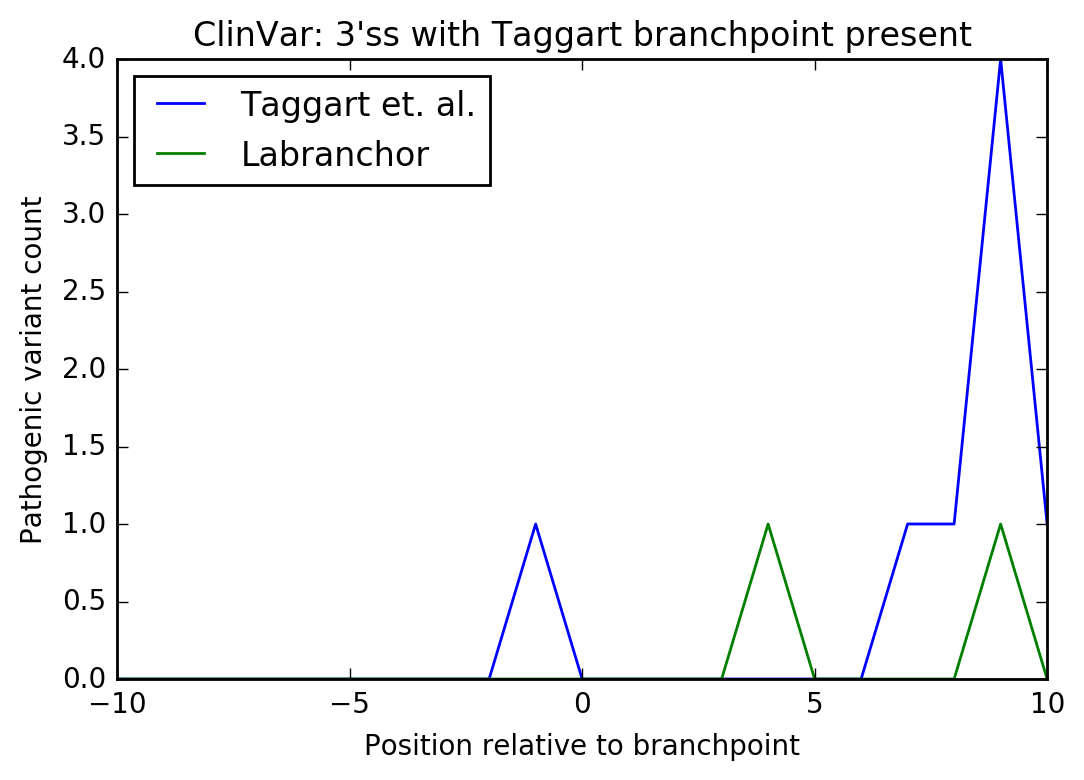

Taggart et. al. branchpoints
CS163247	-4
CS094606	-2
CS099993	-1
CS061318	0
CD012541	0
CS032696	0
CD041169	2
CS154981	3
CS104063	3


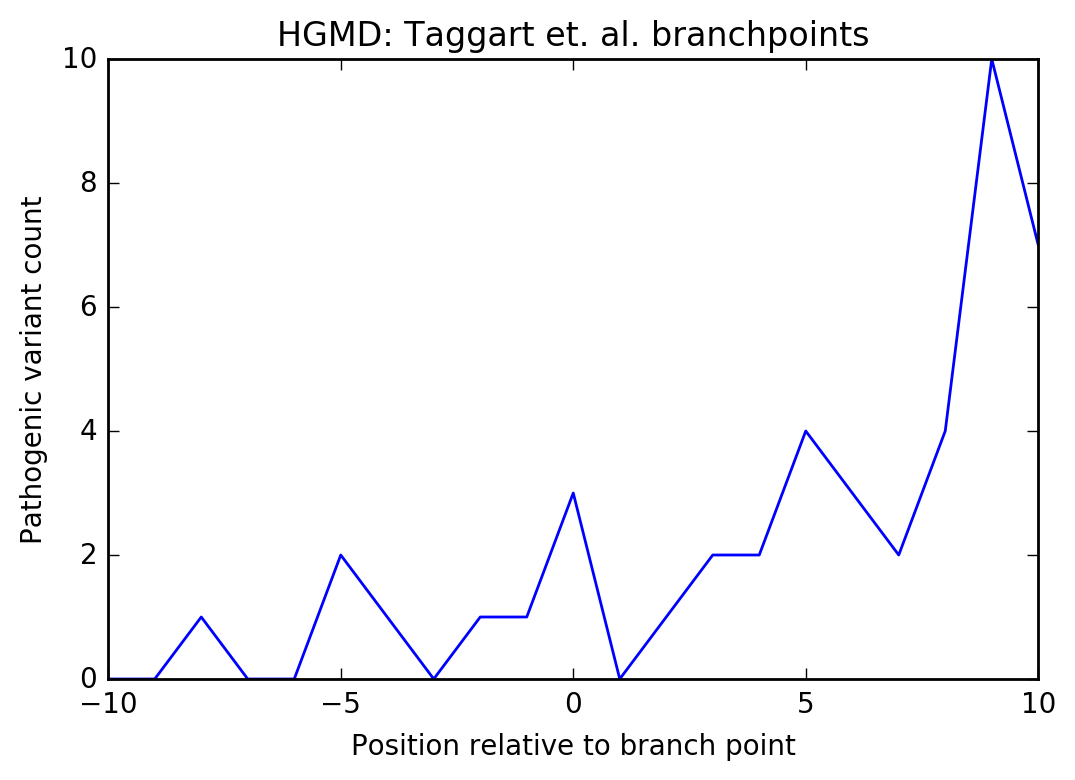

-10 0.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 2.0
-4 1.0
-3 0.0
-2 1.0
-1 1.0
0 3.0
1 0.0
2 1.0
3 2.0
4 2.0
5 4.0
6 3.0
7 2.0
8 4.0
9 10.0
10 7.0
Predictions in Taggart introns
CS991418	-4
CD061423	-4
CS163247	-3
CD035604	-3
CM162580	-2
CX162425	-2
CS061318	0
CD012541	0
CS991417	0
CS032696	0
CD041169	0
CI022300	0
CS1615967	1
CS151592	2
CM158166	3
CS104063	3


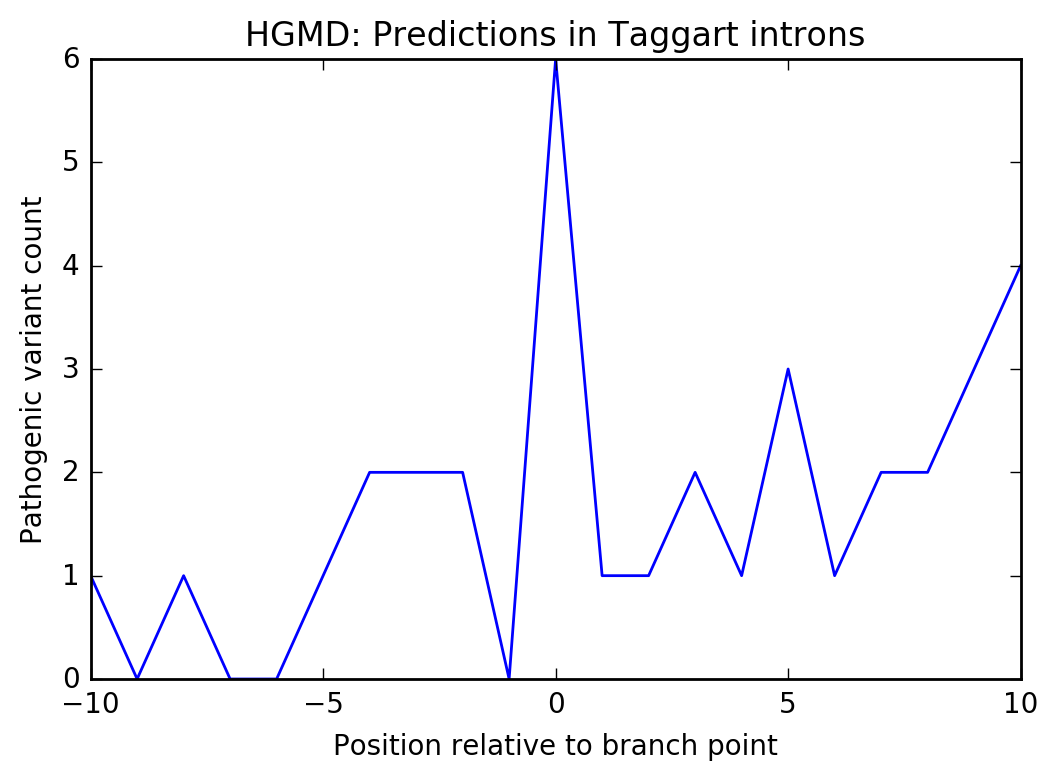

-10 1.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 1.0
-4 2.0
-3 2.0
-2 2.0
-1 0.0
0 6.0
1 1.0
2 1.0
3 2.0
4 1.0
5 3.0
6 1.0
7 2.0
8 2.0
9 3.0
10 4.0
Novel predicted branchpoints
CM950776	-4
CM076452	-4
CD1411572	-4
CD146458	-4
CM950728	-4
CM092221	-4
CS123561	-4
CM132547	-3
CM128900	-3
CS100777	-3
CS961478	-3
CM024611	-3
CD021871	-3
CM981628	-3
CD112599	-3
CS984089	-3
CM970839	-3
CI083382	-3
CX125137	-3
CM015110	-3
CM030009	-3
CS113461	-3
CI1512148	-3
CD099416	-3
CM168309	-3
CM148074	-3
CS152784	-2
CX124736	-2
CD041923	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CM082901	-2
CS000224	-2
CS106163	-2
CS102107	-2
CS120706	-2
CS003079	-2
CM1611380	-2
CD961740	-2
CS120217	-2
CS992243	-2
CM132811	-2
CS051251	-2
CS982129	-2
CD149633	-2
CM152045	-2
CM942314	-2
CD022737	-1
CI041655	-1
CS166863	-1
CS991465	-1
CS160300	-1
CM044928	-1
CM004486	-1
CM101516	-1
CD067566	-1
CS086376	-1
CM096792	-1
CD001911	0
CS961496	0
CS109543	0
CI002561	0
CS1010416	0
CD022908	0
CS061275	0
CS115634	0
CS1510152	0
CS143829	0
CD1110571

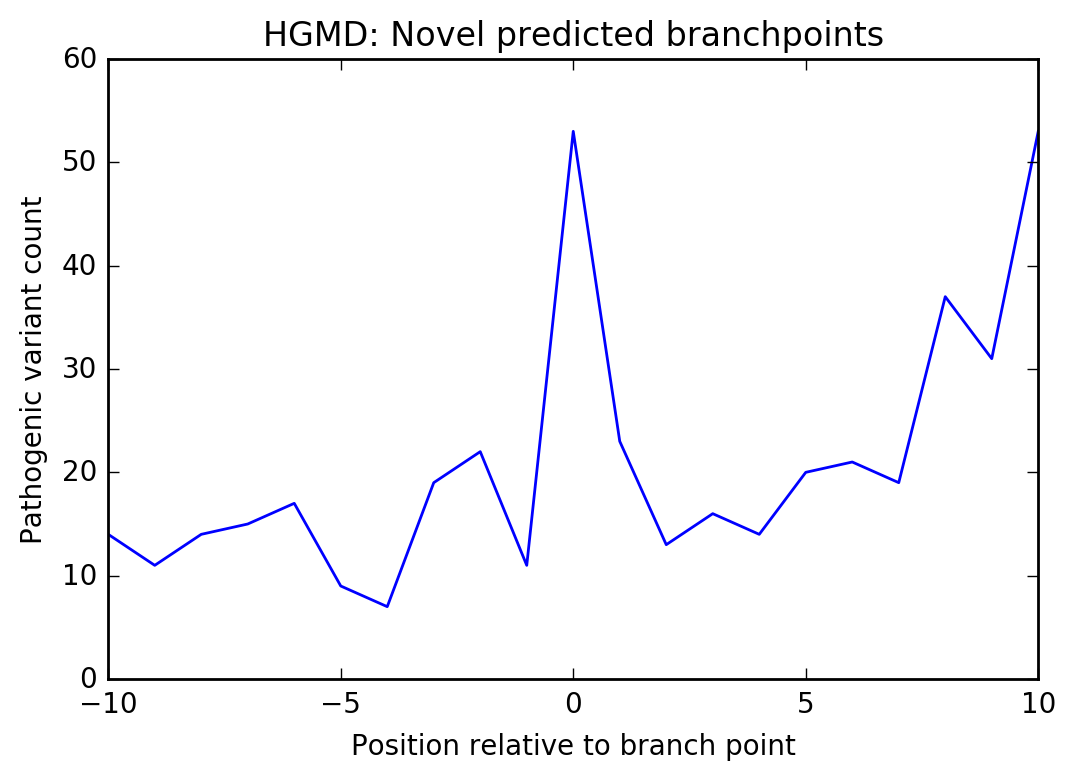

-10 14.0
-9 11.0
-8 14.0
-7 15.0
-6 17.0
-5 9.0
-4 7.0
-3 19.0
-2 22.0
-1 11.0
0 53.0
1 23.0
2 13.0
3 16.0
4 14.0
5 20.0
6 21.0
7 19.0
8 37.0
9 31.0
10 53.0
All predicted branchpoints
CM950776	-4
CM076452	-4
CD061423	-4
CS991418	-4
CD1411572	-4
CD146458	-4
CM950728	-4
CM092221	-4
CS123561	-4
CM132547	-3
CM128900	-3
CS100777	-3
CS961478	-3
CM024611	-3
CD021871	-3
CD035604	-3
CM981628	-3
CD112599	-3
CS163247	-3
CS984089	-3
CM970839	-3
CI083382	-3
CX125137	-3
CM015110	-3
CM030009	-3
CS113461	-3
CI1512148	-3
CD099416	-3
CM168309	-3
CM148074	-3
CS152784	-2
CX124736	-2
CD041923	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CM082901	-2
CS000224	-2
CS106163	-2
CS102107	-2
CS120706	-2
CS003079	-2
CM1611380	-2
CD961740	-2
CS120217	-2
CS992243	-2
CM132811	-2
CS051251	-2
CS982129	-2
CM162580	-2
CD149633	-2
CX162425	-2
CM152045	-2
CM942314	-2
CD022737	-1
CI041655	-1
CS166863	-1
CS991465	-1
CS160300	-1
CM044928	-1
CM004486	-1
CM101516	-1
CD067566	-1
CS086376	-1
CM096792	-1
CD001911	0
CS961496	0
CS109543	0

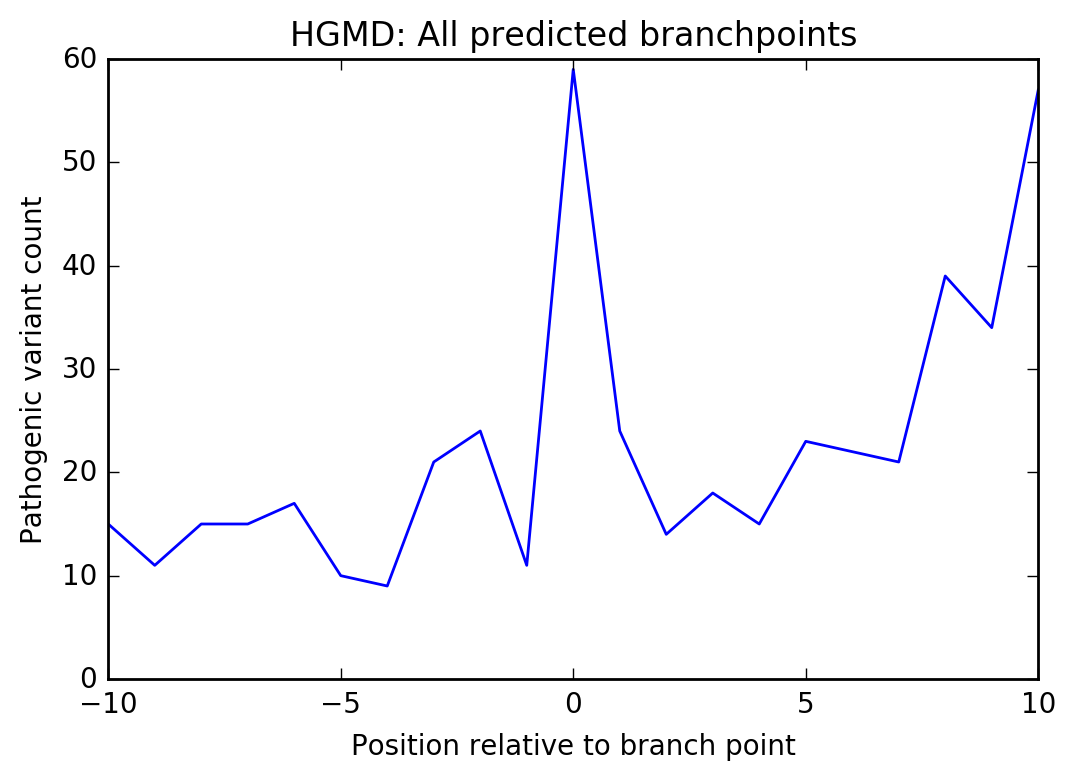

-10 15.0
-9 11.0
-8 15.0
-7 15.0
-6 17.0
-5 10.0
-4 9.0
-3 21.0
-2 24.0
-1 11.0
0 59.0
1 24.0
2 14.0
3 18.0
4 15.0
5 23.0
6 22.0
7 21.0
8 39.0
9 34.0
10 57.0


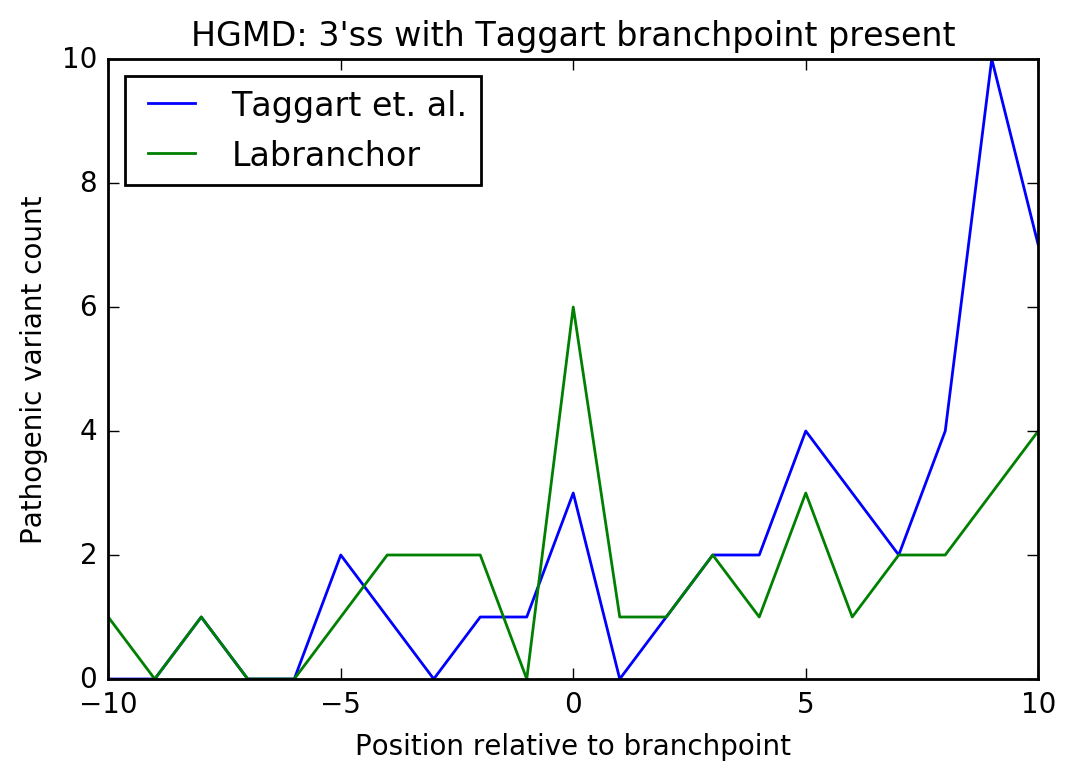

Taggart et. al. branchpoints
CS163247	-4
CS094606	-2
187997	-1
CS061318	0
CD012541	0
CS032696	0
CD041169	2
CS154981	3
CS104063	3


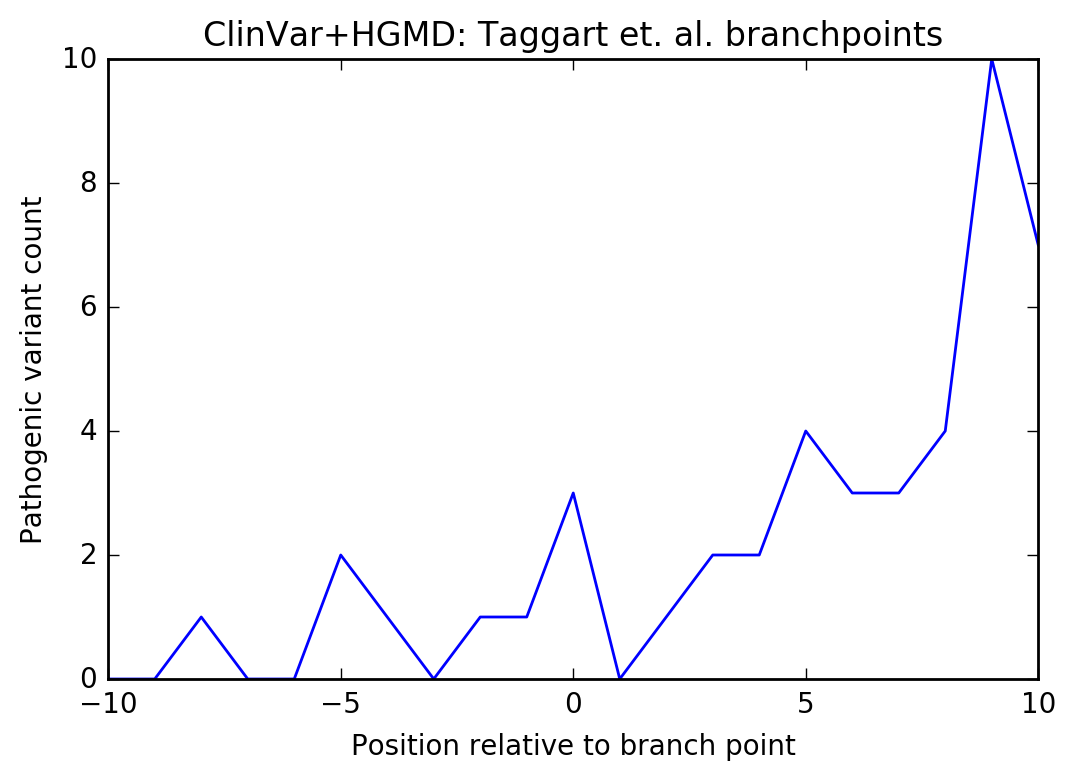

-10 0.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 2.0
-4 1.0
-3 0.0
-2 1.0
-1 1.0
0 3.0
1 0.0
2 1.0
3 2.0
4 2.0
5 4.0
6 3.0
7 3.0
8 4.0
9 10.0
10 7.0
Predictions in Taggart introns
CS991418	-4
CD061423	-4
CS163247	-3
CD035604	-3
CM162580	-2
CX162425	-2
CS061318	0
CD012541	0
CS991417	0
CS032696	0
CD041169	0
CI022300	0
CS1615967	1
CS151592	2
CM158166	3
CS104063	3


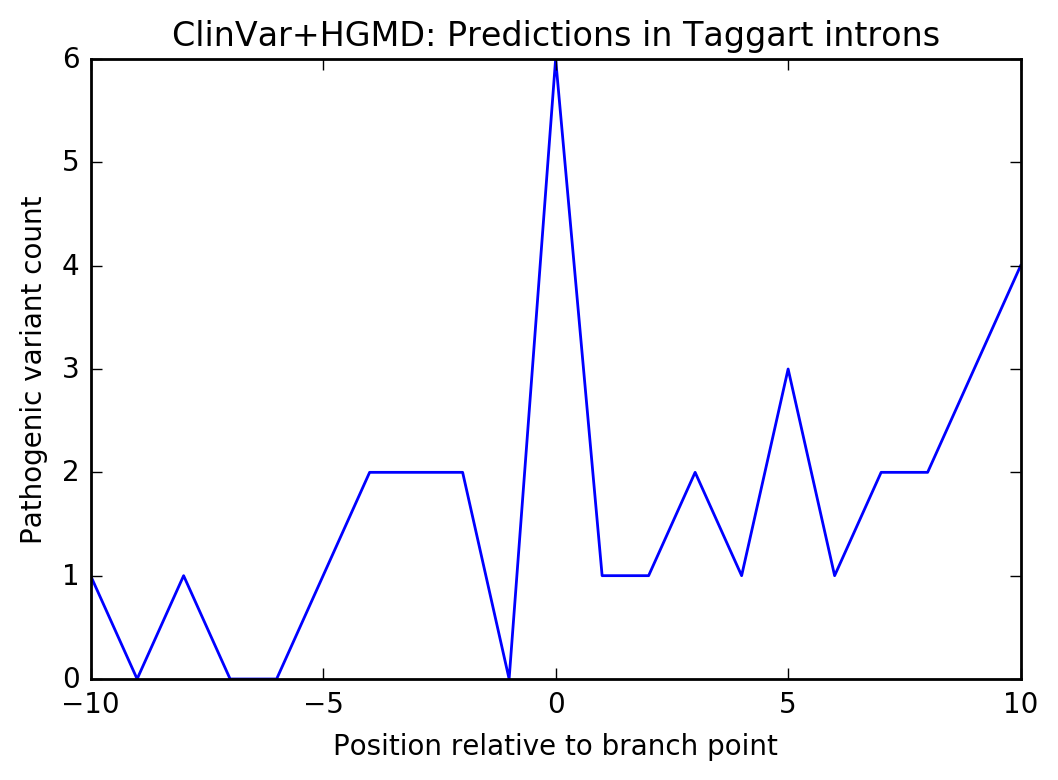

-10 1.0
-9 0.0
-8 1.0
-7 0.0
-6 0.0
-5 1.0
-4 2.0
-3 2.0
-2 2.0
-1 0.0
0 6.0
1 1.0
2 1.0
3 2.0
4 1.0
5 3.0
6 1.0
7 2.0
8 2.0
9 3.0
10 4.0
Novel predicted branchpoints
CM076452	-4
CD1411572	-4
96137	-4
29430	-4
CD146458	-4
CM950728	-4
CS123561	-4
33424	-3
CM128900	-3
CS100777	-3
18060	-3
CM024611	-3
CD021871	-3
CM981628	-3
59489	-3
CD112599	-3
CS984089	-3
CM970839	-3
CI083382	-3
CD961740	-3
CX125137	-3
CM168309	-3
153827	-3
CM015110	-3
CS113461	-3
CI1512148	-3
CD099416	-3
27370	-2
CX124736	-2
CD041923	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CM082901	-2
CS106163	-2
CS152784	-2
207862	-2
CS102107	-2
32227	-2
34160	-2
CM1611380	-2
CS992243	-2
CM132811	-2
CS051251	-2
200318	-2
CD149633	-2
106395	-2
CM152045	-2
CM942314	-2
169295	-2
CD022737	-1
CS166863	-1
CS991465	-1
CI041655	-1
236732	-1
CM044928	-1
CM004486	-1
CD067566	-1
CS086376	-1
CM096792	-1
39097	-1
CD001911	0
CS961496	0
CS109543	0
CI002561	0
CS1010416	0
CS1411892	0
CD022908	0
CS115634	0
CS143829	0
CD1110571	0
CS0911057	0
CS0911056	0

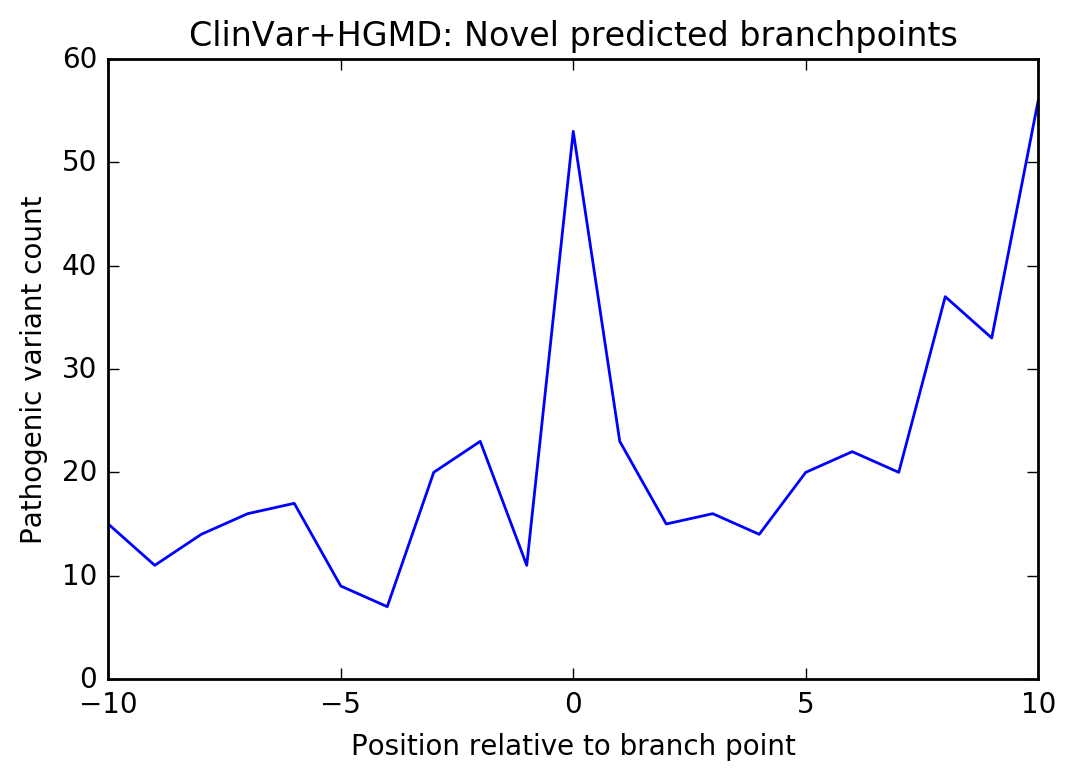

-10 15.0
-9 11.0
-8 14.0
-7 16.0
-6 17.0
-5 9.0
-4 7.0
-3 20.0
-2 23.0
-1 11.0
0 53.0
1 23.0
2 15.0
3 16.0
4 14.0
5 20.0
6 22.0
7 20.0
8 37.0
9 33.0
10 56.0
All predicted branchpoints
CM076452	-4
CD061423	-4
CS991418	-4
CD1411572	-4
96137	-4
29430	-4
CD146458	-4
CM950728	-4
CS123561	-4
33424	-3
CM128900	-3
CS100777	-3
18060	-3
CM024611	-3
CD021871	-3
CD035604	-3
CM981628	-3
59489	-3
CD112599	-3
CS163247	-3
CS984089	-3
CM970839	-3
CI083382	-3
CD961740	-3
CX125137	-3
CM168309	-3
153827	-3
CM015110	-3
CS113461	-3
CI1512148	-3
CD099416	-3
27370	-2
CX124736	-2
CD041923	-2
CS952206	-2
CS971736	-2
CS1614900	-2
CM082901	-2
CS106163	-2
CS152784	-2
207862	-2
CS102107	-2
32227	-2
34160	-2
CM1611380	-2
CS992243	-2
CM132811	-2
CS051251	-2
200318	-2
CM162580	-2
CD149633	-2
CX162425	-2
106395	-2
CM152045	-2
CM942314	-2
169295	-2
CD022737	-1
CS166863	-1
CS991465	-1
CI041655	-1
236732	-1
CM044928	-1
CM004486	-1
CD067566	-1
CS086376	-1
CM096792	-1
39097	-1
CD001911	0
CS961496	0
CS109543	0
CI002561	0
CS1

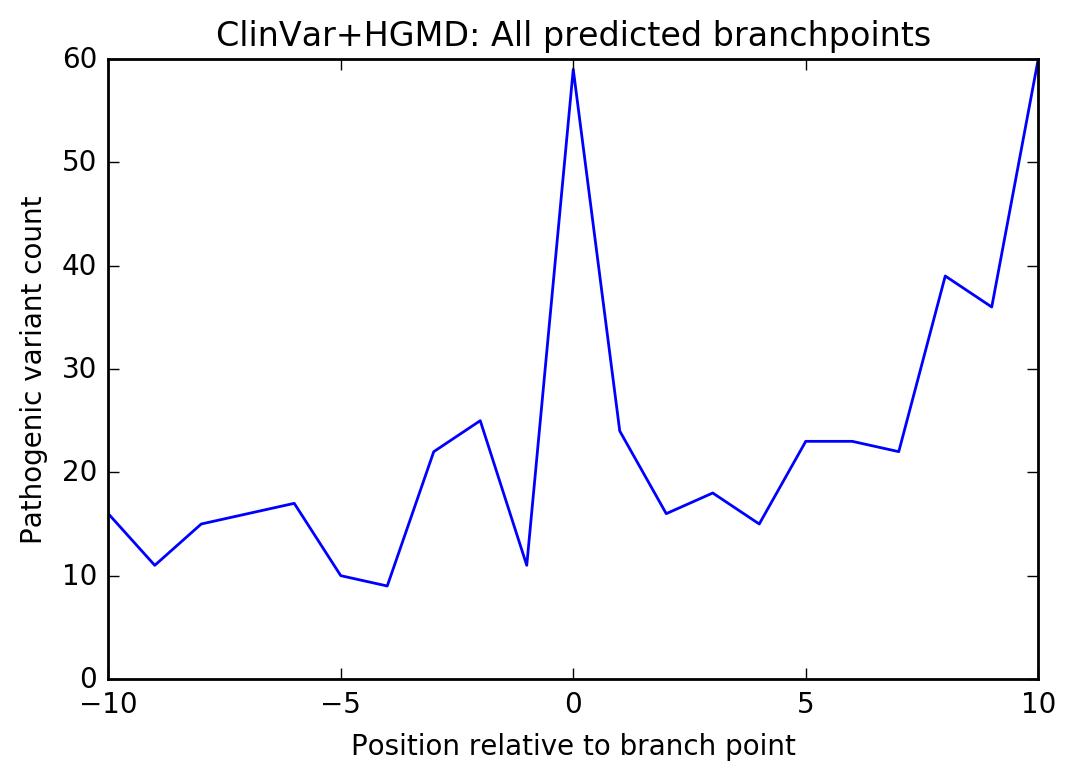

-10 16.0
-9 11.0
-8 15.0
-7 16.0
-6 17.0
-5 10.0
-4 9.0
-3 22.0
-2 25.0
-1 11.0
0 59.0
1 24.0
2 16.0
3 18.0
4 15.0
5 23.0
6 23.0
7 22.0
8 39.0
9 36.0
10 60.0


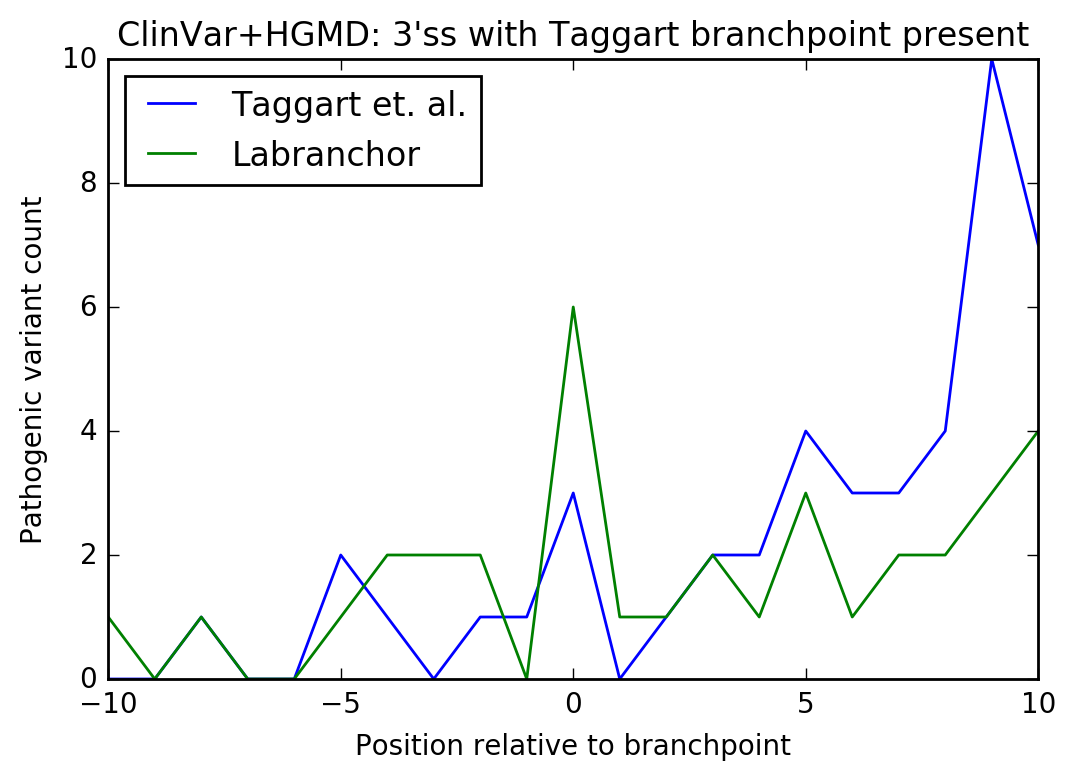

In [23]:
hgmd = []
with open('../anno/hgmd2017.se.vcf') as fp:
    for line in fp:
        if line[0] == '#':
            continue
        chrom, pos, ID, ref, alt, qual, filt, info = line.strip().split()

        for i in range(len(ref)):
            hgmd += [('chr'+chrom, int(pos)+i, ID, ref, alt)]

clinvar = []
with open('../anno/clinvar.se.vcf') as fp:
    for line in fp:
        if line[0] == '#':
            continue
        chrom, pos, ID, ref, alt, qual, filt, info = line.strip().split()
        
        for i in range(len(ref)):
            clinvar += [('chr'+chrom, int(pos)+i, ID, ref, alt)]

clinvar_idx = set()
for chrom, start, rs, ref, alt in clinvar:
    clinvar_idx.add((chrom, start, alt))
clin_hgmd = [item for item in clinvar]
for chrom, start, rs, ref, alt in hgmd:
    if (chrom, start, alt) not in clinvar_idx:
        clin_hgmd += [(chrom, start, rs, ref, alt)]

print len(hgmd)    
print len(clinvar)
print len(clin_hgmd)

names = ['Taggart et. al. branchpoints',
         'Predictions in Taggart introns',
         'Novel predicted branchpoints',
         'All predicted branchpoints']
bps = [k_bps, p_bps, n_bps, a_bps]

for v, title in zip([clinvar, hgmd, clin_hgmd],
                    ['ClinVar', 'HGMD', 'ClinVar+HGMD']):
    path = []
    for bp, name in zip(bps, names):
        print name
        path += [var_enrichment(v, bp, title == 'ClinVar')]
        plt.plot(range(-10, 11), path[-1])
        plt.title("{}: {}".format(title, name))
        plt.xlabel('Position relative to branch point')
        plt.ylabel("Pathogenic variant count")
        plt.show()
        for i, c in zip(range(-10, 11), path[-1]):
            print i, c
    
    for name, hits in zip(['Taggart et. al.', 'Labranchor'], path)[:2]:
        plt.plot(range(-10, 11), hits, label = name)
    plt.title("{}: 3'ss with Taggart branchpoint present".format(title))
    plt.xlabel('Position relative to branchpoint')
    plt.ylabel("Pathogenic variant count")
    plt.legend(loc = 2)
    plt.show()